# Model Processing

## Imports & General Settings 

In [2]:
import unittest
import os
import sys
import time
import pathlib

import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage
import PIL
from tqdm.notebook import trange, tqdm
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_curve, roc_auc_score
from matplotlib import pyplot
from scipy.signal import resample


# Our imports
from data import WaveletTransform, AFECGDataset, SecondDataset, WrapperDataset
import dsp
from model.blocks import ConvNet, BRNN, SoftmaxAttention
from model.baseline import Baseline
from training import train, test
import utils


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
testCase = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Dataset creation

In [4]:
dataset_name = 'afdb'
dataset = AFECGDataset(dataset_name, '../data/afdb/', wavelet=WaveletTransform(resample=20))

In [5]:
# dataset.load(num_records=1)
dataset.load('./temp/' + dataset_name)

Loaded from backup


In [9]:
images_per_sample = 20
total_data_size = len(dataset)
print("Total data size: ", total_data_size)
print("Samples with AF: ", dataset.labels.sum().item())
print(dataset.samples.shape)

Total data size:  1397
Samples with AF:  216
torch.Size([1397, 20, 92, 375])


##  Wavelet Transform

Has AF:  Yes


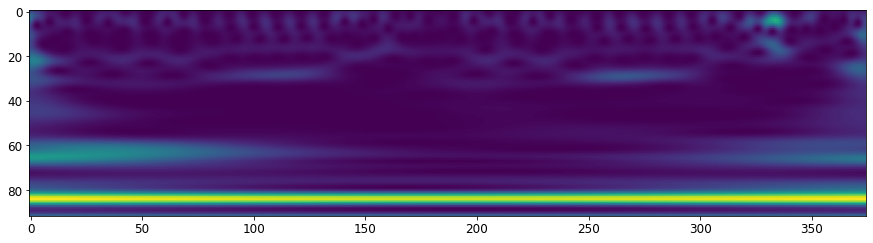

In [7]:
powers, label = dataset[0]
print('Has AF: ', 'Yes' if label == 1 else 'No')

signal = powers[0] # resample(powers[0], 375)
plt.figure(figsize=(15, 15))
plt.imshow(signal)
plt.show()

Has AF:  No


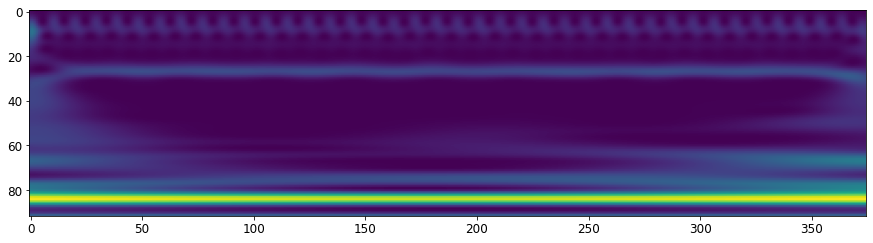

In [8]:
powers, label = dataset[3]
print('Has AF: ', 'Yes' if label == 1 else 'No')

signal = powers[0] # resample(resample(powers[0], 300, axis=1), 300)
plt.figure(figsize=(15, 15))
plt.imshow(signal)
plt.show()

Has AF:  No


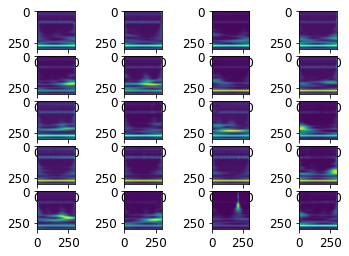

In [19]:
powers, label = dataset[3]
print('Has AF: ', 'Yes' if label == 1 else 'No')

fig, axes = plt.subplots(5, 4)
axes = axes.reshape(-1)
for power, ax in zip(powers, axes):
    signal = resample(resample(power, 300, axis=1), 300)
    ax.imshow(signal)

plt.show()

## Training

In [20]:
heldout = int(len(dataset) * 0.2)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - heldout, heldout])
train_indices = train_dataset.indices
test_indices = test_dataset.indices
print('[Train] Positive cases = {}'.format((dataset.labels[train_indices] == 1).sum()))
print('[Test] Positive cases = {}'.format((dataset.labels[test_indices] == 1).sum()))

[Train] Positive cases = 171
[Test] Positive cases = 45


### Baseline

In [24]:
model = Baseline()

config = dict(
    num_workers=2,
    batch_size=30,
    learning_rate=0.001,
    weight_decay=0.01,
    num_epochs=4,
    is_notebook=True
)

train(model, train_dataset, config)

torch.Size([30, 50])
tensor([[ 0.0727,  0.1028, -0.1599,  ..., -0.1296, -0.0539,  0.1344],
        [ 0.2653,  0.1755, -0.2466,  ...,  0.1543,  0.0306,  0.0603],
        [ 0.1493, -0.1316, -0.1940,  ..., -0.0612,  0.2290,  0.2257],
        ...,
        [ 0.3633, -0.1047, -0.0296,  ..., -0.1462, -0.2154,  0.2133],
        [ 0.1618,  0.0679, -0.1352,  ..., -0.0413,  0.1805,  0.1785],
        [-0.1181,  0.1782, -0.0947,  ...,  0.1129,  0.0342,  0.3148]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.1154,  0.0986,  0.1226,  ...,  0.0854,  0.2199, -0.3327],
        [ 0.0787,  0.0283,  0.1430,  ...,  0.1405,  0.0205, -0.4761],
        [ 0.0378,  0.1577,  0.1350,  ...,  0.1654,  0.1877, -0.3981],
        ...,
        [ 0.1351,  0.2133,  0.0797,  ...,  0.0180,  0.0190, -0.3629],
        [-0.0641,  0.0253,  0.1257,  ...,  0.1414,  0.1701, -0.2920],
        [ 0.1423,  0.0559,  0.2359,  ...,  0.3166,  0.3446, -0.3223]],
       grad_fn=<AddmmBackward>)
After CNN= torch.Size([20, 30, 50])
After BRNN=

Ground truth: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 3.8108,  3.3412,  2.3613,  ..., -7.7229, -4.3476, -1.8893],
        [ 4.1178,  3.7768,  2.6044,  ..., -8.7856, -4.7892, -2.0916],
        [ 3.8053,  3.3546,  2.3748,  ..., -7.7181, -4.3492, -1.8959],
        ...,
        [ 2.1755,  1.8979,  1.3115,  ..., -4.4300, -2.4413, -1.0516],
        [ 1.9135,  1.6919,  1.1495,  ..., -3.9925, -2.1616, -0.9343],
        [ 3.3517,  2.9144,  2.0501,  ..., -6.7509, -3.7497, -1.6724]],
       grad_fn=<AddmmBackward>)
tensor([[ 9.1219,  0.4804, 10.2909,  ..., -2.9778, -0.7841, -2.0736],
        [15.8344,  0.9473, 17.7396,  ..., -5.1135, -1.4881, -3.4989],
        [12.6041,  0.7753, 13.9762,  ..., -4.2524, -1.0885, -2.8670],
        ...,
        [12.3583,  0.7580, 13.7840,  ..., -4.1496, -1.0224, -2.7901],
        [ 8.6537,  0.2336, 10.0423,  ..., -2.5114, -0.6740, -1.7524],
        [12.1013,  0.7418, 13.5388,  ..., -4.1

Ground truth: tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0])
Prediction: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([30, 50])
tensor([[ 0.0994,  0.2313,  0.2552,  ..., -0.8818, -0.3766, -0.3841],
        [ 0.0631,  0.1143,  0.1181,  ..., -0.3472, -0.1502, -0.1723],
        [ 0.0537,  0.1325,  0.1486,  ..., -0.5084, -0.2280, -0.2118],
        ...,
        [ 0.0490,  0.1173,  0.1243,  ..., -0.4335, -0.1668, -0.1881],
        [ 0.0428,  0.1930,  0.2150,  ..., -0.8403, -0.3359, -0.3518],
        [ 0.0735,  0.2025,  0.2264,  ..., -0.8358, -0.3395, -0.3719]],
       grad_fn=<AddmmBackward>)
tensor([[ 6.7772e-01,  7.0500e-03,  9.7028e-01,  ..., -1.6538e-01,
         -5.8640e-02, -2.2187e-01],
        [ 7.5022e-01,  8.3387e-03,  1.1170e+00,  ..., -1.7628e-01,
         -8.2144e-02, -2.3866e-01],
        [ 2.3578e+00, -6.7614e-02,  3.4999e+00,  ..., -2.9710e-01,
         -1.1793e-01, -7.2476e-01],
        ...,
        [ 6.4479e-01, -1.1214e-03,  1.0128e+00,  ..., -1.6106e-01,
         -6.9791e-02

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[   1.0450,   -9.1660,    3.8476,  ...,    4.3733,  -11.8795,
            9.3539],
        [ 198.4955, -286.0711,  206.0779,  ...,  217.5745, -193.6685,
          235.9277],
        [  32.8603,  -50.7211,   35.9865,  ...,   37.4878,  -38.5681,
           43.9127],
        ...,
        [  57.4577,  -90.5618,   62.1573,  ...,   65.9090,  -64.1176,
           75.2859],
        [ 241.5278, -358.2115,  254.4196,  ...,  268.1752, -248.9891,
          297.6119],
        [ 173.7500, -265.3208,  185.9507,  ...,  196.0911, -188.9182,
          222.4481]], grad_fn=<AddmmBackward>)
tensor([[  78.6079,  -60.6133,   95.4297,  ...,   92.9635,   98.6190,
           11.0519],
        [ 109.5571,  -98.3445,  153.9352,  ...,  139.7704,  154.4351,
           10.9295],
        [  65.5813,  -52.9861,   81.5825,  ...,   78.4660,   84.9498,
           10.1383],
        ...,
    

Ground truth: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 1])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 702.0737,  801.2571,  845.5344,  ..., -665.1310,  750.4212,
         -770.3593],
        [ 711.1426,  809.2127,  886.0461,  ..., -633.2877,  788.2897,
         -798.2424],
        [ 681.8915,  624.1566,  854.2721,  ..., -490.4450,  703.7377,
         -680.4954],
        ...,
        [ 369.0803,  332.6878,  459.1416,  ..., -280.6268,  356.9412,
         -360.9264],
        [ 808.0121,  825.4758,  989.1388,  ..., -661.1985,  858.4697,
         -853.3319],
        [ 488.7875,  468.6728,  617.3715,  ..., -367.5556,  511.8902,
         -495.9911]], grad_fn=<AddmmBackward>)
tensor([[ -20.7671,  251.4185,  210.8314,  ..., -286.8653,  384.7786,
          -13.6730],
        [ -15.2033,  205.3763,  179.1756,  ..., -237.9762,  322.7452,
           -2.6729],
        [ -36.2211,  309.7550,  235.6101,  ..., -368.2762,  456.8315,
           -6.8824],
        ...,
    

Ground truth: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 110.1904,  255.5094,  388.8299,  ...,  -72.1040,  228.5279,
         -233.8926],
        [ 116.5200,  272.3239,  399.6205,  ...,  -88.8371,  242.2492,
         -241.3619],
        [ 158.1711,  373.7592,  571.3869,  ..., -112.0080,  336.9669,
         -333.1126],
        ...,
        [ 192.6656,  396.7686,  569.6672,  ..., -136.1434,  358.9042,
         -356.9284],
        [  97.0475,  211.4063,  318.6784,  ...,  -74.6607,  191.4202,
         -190.2893],
        [  73.5157,  167.9316,  263.4296,  ...,  -52.0062,  152.2266,
         -154.7255]], grad_fn=<AddmmBackward>)
tensor([[-154.6583,   21.6941,  -22.6090,  ...,  -36.2338,   68.4378,
         -151.3291],
        [-191.2062,   26.6783,  -40.2554,  ...,  -51.8263,   62.4977,
         -179.3127],
        [-232.1713,   46.7311,  -35.5216,  ...,  -82.6553,  120.1319,
         -217.5495],
        ...,
    

Ground truth: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[  48.9658,  153.7178,  282.8321,  ...,  -25.9870,  137.8020,
         -124.8244],
        [  32.5449,  102.5153,  195.8454,  ...,  -15.5514,   92.6996,
          -84.5957],
        [  54.8053,  155.2291,  271.5403,  ...,  -29.0985,  140.4669,
         -127.8917],
        ...,
        [  57.1286,  167.6318,  297.6428,  ...,  -30.9307,  151.5761,
         -137.0497],
        [  24.5336,   69.7214,  129.2949,  ...,  -11.3013,   63.9429,
          -58.9040],
        [  14.3800,   63.3509,  135.5269,  ...,   -7.7302,   60.3698,
          -51.3373]], grad_fn=<AddmmBackward>)
tensor([[-36.6077,  -7.4298,  -0.3559,  ..., -29.0225,  34.2557, -25.2133],
        [-24.4932,  -4.3953,  -0.6845,  ..., -18.7513,  26.8273, -18.0085],
        [-30.4420,  -8.0127,  -6.1412,  ..., -21.3064,  11.6297, -20.3920],
        ...,
        [-41.7979, -12.9443, -11.0638,  ..., -28.

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 19.2837,  86.4550, 172.5428,  ..., -11.1518,  76.5793, -65.9259],
        [ 14.0668,  78.9964, 164.7106,  ...,  -9.8189,  68.7547, -58.2022],
        [ 19.5006,  85.1189, 170.6490,  ..., -10.5893,  75.4211, -65.3404],
        ...,
        [  6.2584,  38.3000,  82.5673,  ...,  -4.7132,  32.9721, -27.9430],
        [  9.2448,  58.9759, 122.1203,  ...,  -7.8056,  52.5358, -42.6791],
        [  9.5197,  48.7342, 102.1416,  ...,  -6.0035,  45.4966, -37.3466]],
       grad_fn=<AddmmBackward>)
tensor([[-19.0868,  -3.0078,  -2.5257,  ...,  -8.7036, -17.3830,   5.1827],
        [-40.6946,  15.7978,  -5.3392,  ..., -30.5280,   8.7536,  13.7957],
        [-18.3254,  -1.1083,   0.7970,  ...,  -7.7602, -10.2840,   5.8779],
        ...,
        [-22.2015,  10.0535,  -0.9369,  ..., -16.1338,   8.2083,   8.0737],
        [-47.6797,  23.4460, -11.1508,  ..., -40.8426,  

Ground truth: tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[  8.1527,  44.7449, 109.2910,  ...,  -3.3335,  39.0756, -33.1310],
        [  7.9582,  41.0576,  96.9990,  ...,  -3.1046,  36.1610, -30.7077],
        [  0.8841,   8.6762,  26.3555,  ...,  -0.3232,   7.6133,  -6.4854],
        ...,
        [  4.4746,  31.5408,  80.2283,  ...,  -2.4098,  26.8901, -22.0065],
        [  4.5223,  29.8414,  75.8922,  ...,  -2.1931,  25.2615, -21.3953],
        [  7.9484,  44.1044, 107.9980,  ...,  -3.2971,  38.3853, -32.6124]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.6474,  3.3016,  8.5616,  ..., -4.9274, 14.6545, -3.9285],
        [ 2.2744,  2.4486,  8.0171,  ..., -2.0614, 13.0856, -1.7957],
        [ 1.5886,  2.5328,  7.8400,  ..., -2.6700, 11.8757, -2.6877],
        ...,
        [ 0.1119,  2.7074,  5.1820,  ..., -4.6220,  9.0025, -2.6274],
        [ 1.3628,  3.2364,  8.4311,  ..., -3.6404, 13.9779, -3.1848],
        [ 

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[  0.6781,   3.2866,  24.5487,  ...,   1.1668,   5.0559,  -4.1186],
        [  4.0185,  21.9577,  59.7495,  ...,  -0.8733,  19.5302, -16.5574],
        [  3.6063,  20.0180,  53.7620,  ...,  -0.8121,  17.6071, -14.8695],
        ...,
        [  2.8707,  14.8658,  38.6878,  ...,  -0.6325,  13.4474, -11.2961],
        [  3.7137,  19.0410,  48.9072,  ...,  -0.7928,  17.2295, -14.6098],
        [  1.3199,   9.7441,  30.7198,  ...,  -0.2343,   7.7275,  -6.9327]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.0810, -0.0404,  5.7169,  ..., -0.6796,  5.9607, -0.1058],
        [ 3.2368, -0.9038,  7.6699,  ...,  3.8633, 10.0266, -0.1594],
        [ 3.2039, -0.5823,  8.0711,  ...,  3.4411, 11.1545, -0.1141],
        ...,
        [ 0.6230, -0.3998,  2.0177,  ...,  0.7442,  2.4637, -0.0987],
        [ 3.1072, -0.9544,  6.0285,  ...,  3.4750,  7.7014, -0.1941],
        [ 

Ground truth: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[-0.6257,  3.1802, 11.5685,  ..., -0.5386,  2.2447, -1.7855],
        [-0.1634,  2.0445, 19.6554,  ...,  0.6205,  4.9135, -3.8308],
        [ 0.2520, 11.9822, 36.9023,  ..., -1.0801, 10.0176, -8.3600],
        ...,
        [-0.5725,  6.8313, 24.5963,  ..., -0.8055,  5.7283, -4.5228],
        [-0.3488,  8.0528, 27.7908,  ..., -0.9024,  6.4626, -5.3698],
        [-0.7895,  1.6226,  7.5152,  ..., -0.4446,  0.8973, -0.6919]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.0732, -0.2952,  2.2057,  ...,  1.8174,  2.8289,  0.7054],
        [ 2.6537, -0.7710,  6.2761,  ...,  5.7383,  7.9410,  1.1839],
        [ 2.1507, -0.3872,  5.8141,  ...,  4.9288,  7.8253,  1.0738],
        ...,
        [-0.3482, -0.4028,  1.8817,  ...,  1.9386,  2.6565,  0.9228],
        [ 2.0496, -0.4197,  5.4118,  ...,  4.6382,  7.0863,  0.9465],
        [ 2.6444, -0.9185,  6.3984,  ...,  5.4

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[-1.5805,  5.0007, 13.7219,  ..., -1.7612,  4.1440, -3.1730],
        [-1.1973,  4.6652, 12.3098,  ..., -1.4941,  3.9865, -3.1099],
        [-0.6565,  3.4983,  9.6028,  ..., -0.9201,  3.2251, -2.4137],
        ...,
        [-1.3962,  4.6288, 12.4682,  ..., -1.6412,  3.8442, -2.9677],
        [-1.0340,  3.2959,  9.1392,  ..., -1.1182,  2.8544, -2.2370],
        [-1.4228,  4.8701, 13.2689,  ..., -1.6992,  4.0542, -3.1177]],
       grad_fn=<AddmmBackward>)
tensor([[-1.6357,  1.7630,  0.2388,  ..., -3.4768,  6.3169,  1.7817],
        [-2.2085,  3.1578,  0.1035,  ..., -5.0265,  9.9409,  2.3011],
        [-0.5837,  5.3742,  2.4339,  ..., -4.0076, 13.5829,  1.3777],
        ...,
        [-1.9858,  4.6318,  0.1779,  ..., -5.7750, 13.1944,  2.4311],
        [-0.5793, -0.9708,  1.6857,  ..., -0.5517,  3.3183,  1.3484],
        [-1.9305,  1.2729, -0.1927,  ..., -3.9

Ground truth: tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[-0.9148,  0.7906,  5.5559,  ...,  0.6054,  1.5055, -0.9527],
        [-1.9075, -3.3339, -0.6055,  ...,  0.6721, -0.1599,  0.3361],
        [ 0.8657, -1.3842,  0.5620,  ...,  1.9852, -0.0208,  0.7923],
        ...,
        [-1.0073, -0.2570,  2.2792,  ...,  0.5173,  0.4302, -0.0151],
        [-0.6295,  0.8103,  5.9311,  ...,  0.8175,  1.6476, -0.8374],
        [-1.7830,  2.1207,  4.7414,  ..., -0.9917,  1.4113, -1.3605]],
       grad_fn=<AddmmBackward>)
tensor([[-10.0225,   2.1430,  -0.0140,  ...,  -2.5165,   5.6642,  -1.4813],
        [ -1.5526,   1.7342,   2.9275,  ...,   2.8239,   8.0809,   1.2773],
        [ -2.9210,   1.7069,   1.1202,  ...,  -0.4311,   3.6801,  -0.8379],
        ...,
        [ -6.9166,   2.9513,  -1.4540,  ...,  -0.5437,   6.0912,   0.4758],
        [-12.9838,   3.3757,  -4.1152,  ...,  -4.3871,   4.4747,  -0.9499],
        [ -8.964

Ground truth: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[-1.7023, -0.2276, -0.2312,  ..., -1.7854, -0.0266, -0.6305],
        [-2.1056,  1.8767,  3.1380,  ..., -2.2715,  0.9100, -1.2275],
        [-2.8213,  1.3974,  3.6044,  ..., -3.0694,  0.9471, -1.7458],
        ...,
        [-1.1203,  0.7287,  1.0945,  ..., -1.0406,  0.3176, -0.4507],
        [-1.5347,  0.8090,  0.8394,  ..., -1.8530,  0.1235, -0.6629],
        [-3.2663,  1.4949,  3.1788,  ..., -3.2217,  0.9190, -1.7277]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.1421,  0.0498,  1.5004,  ...,  1.4497,  2.6988,  0.2939],
        [-3.5802,  1.3016, -0.7724,  ..., -0.2843,  3.3203,  0.1635],
        [-2.9758,  1.0918, -0.7393,  ..., -0.0565,  2.5974,  0.1945],
        ...,
        [-0.9738,  0.8432,  0.2478,  ..., -0.3846,  1.6359, -0.2263],
        [-5.2876,  2.8028, -2.8158,  ..., -3.2899,  1.3896, -0.7099],
        [-4.6397,  2.1578, -1.1784,  ..., -0.7

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[13.1855, -1.9572,  9.5767,  ...,  8.7433,  5.1323, -0.6701],
        [ 7.9167, -0.6256,  7.3292,  ...,  5.2111,  3.3766, -0.7071],
        [ 7.2479, -0.5902,  6.8252,  ...,  4.8551,  3.0412, -0.6353],
        ...,
        [ 8.9610, -1.1808,  6.6492,  ...,  5.9760,  3.4440, -0.4585],
        [16.0172, -2.8115, 10.7625,  ..., 10.6080,  6.2743, -0.6893],
        [15.3413, -2.1877, 10.7583,  ..., 10.1911,  5.9787, -0.7148]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.7059,  1.1677,  4.5116,  ..., -1.1226,  5.9254, -2.5289],
        [-0.8932,  2.7457,  2.3217,  ..., -3.6744,  3.1442, -2.3740],
        [-0.8135,  2.7639,  2.3386,  ..., -3.6904,  3.1734, -2.3781],
        ...,
        [-0.7551,  2.1708,  2.5720,  ..., -2.6411,  3.7459, -2.1793],
        [-0.1601,  1.4187,  3.1739,  ..., -1.6181,  4.5745, -2.0862],
        [-0.4479,  1.4613,  2.5324,  ..., -1.7

Ground truth: tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[-7.2200,  1.2580, -2.0071,  ..., -5.3733, -1.5329, -1.1647],
        [-2.8727, -0.4222, -1.3247,  ..., -2.2164, -1.3057, -0.3538],
        [-1.8050,  0.3465, -0.8503,  ..., -1.2161, -0.5737, -0.2971],
        ...,
        [-6.3089,  2.1279, -3.5375,  ..., -4.1647, -2.4193, -0.9516],
        [-6.1736,  1.8444, -3.3479,  ..., -4.2060, -2.3796, -0.9135],
        [-6.5207,  0.7458, -1.0413,  ..., -5.1073, -1.3421, -1.0804]],
       grad_fn=<AddmmBackward>)
tensor([[-15.2703,  10.1726,  -7.5863,  ...,  -1.0471,   5.3728,   3.4990],
        [-10.2596,   6.7656,  -8.2915,  ...,   2.6264,   0.6992,   5.5619],
        [-12.5099,   8.0898,  -5.8838,  ...,  -0.4023,   4.6076,   2.9130],
        ...,
        [-14.0358,   9.1678, -12.7856,  ...,   6.0178,  -1.2422,   9.0859],
        [-12.8525,   8.8568, -11.4697,  ...,   6.5685,  -0.0206,   9.4268],
        [ -9.941

Ground truth: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 0.1282,  0.1204, -0.3583,  ...,  0.5423, -0.7690, -0.1590],
        [ 1.7406, -0.8017,  0.1500,  ...,  1.8546, -1.0864,  0.1651],
        [ 2.2047, -0.9360,  0.2869,  ...,  2.2837, -1.1365,  0.1940],
        ...,
        [ 1.7921, -0.9335,  0.0494,  ...,  2.0517, -1.2047,  0.1797],
        [ 2.0722, -0.9565,  0.7624,  ...,  2.0344, -0.7879,  0.2763],
        [ 1.5810, -0.9434,  0.0292,  ...,  1.8418, -1.1091,  0.1757]],
       grad_fn=<AddmmBackward>)
tensor([[1.6966, 0.3258, 2.9949,  ..., 1.6970, 3.1928, 0.4653],
        [3.2720, 0.4689, 4.2108,  ..., 2.6361, 4.0312, 1.1740],
        [3.6060, 0.4140, 4.3998,  ..., 2.7046, 4.4955, 1.1432],
        ...,
        [2.6169, 0.2877, 2.7504,  ..., 1.8330, 2.1870, 1.3765],
        [1.6824, 0.4079, 2.3509,  ..., 0.6490, 2.0753, 0.8937],
        [2.5776, 0.3943, 3.2025,  ..., 2.0189, 2.8832, 1.0015]],
       grad

Ground truth: tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[-0.1543, -0.2904, -0.8415,  ...,  0.0803, -0.5653, -0.1694],
        [ 0.2335,  0.2247,  0.2007,  ...,  0.1307,  1.0710, -0.5233],
        [ 0.1044, -0.2456,  0.0050,  ...,  0.3460,  0.6996, -0.4140],
        ...,
        [ 0.1281, -0.1613, -0.4949,  ...,  0.0684, -0.0041, -0.2828],
        [ 0.2116,  0.2305,  0.1599,  ...,  0.0684,  0.9932, -0.4948],
        [ 0.0068, -0.0119, -0.5776,  ...,  0.0282,  0.0042, -0.3329]],
       grad_fn=<AddmmBackward>)
tensor([[  2.2980,  -6.0474,   1.4613,  ...,  13.7470,  -1.0331,  -6.8991],
        [  1.3165, -13.4189,  -2.1739,  ...,  19.7398, -11.6663,  -6.8496],
        [  3.0092, -13.5154,  -0.3874,  ...,  19.7656,  -9.3391,  -4.2564],
        ...,
        [  1.7540,  -6.1047,   2.3480,  ...,  13.8277,  -1.0108,  -7.7439],
        [  0.5757, -14.8713,  -0.8148,  ...,  24.8669, -11.7829, -11.9280],
        [  0.851

Ground truth: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 0.8413, -0.2310,  0.4037,  ...,  0.5821,  0.3189, -0.1904],
        [ 0.2580,  0.3221,  0.1809,  ..., -0.0541,  0.2126, -0.2238],
        [ 0.8207, -0.2282,  0.3439,  ...,  0.5142,  0.3071, -0.2116],
        ...,
        [ 0.6886, -0.0945,  0.3014,  ...,  0.3446,  0.2925, -0.2324],
        [ 0.2453, -0.1343,  0.1146,  ...,  0.0970,  0.1075, -0.1339],
        [ 0.0669, -0.0033,  0.2278,  ..., -0.0663,  0.0559, -0.1330]],
       grad_fn=<AddmmBackward>)
tensor([[ 4.8159, -0.7952,  7.1396,  ...,  6.1607,  7.6192, -2.2695],
        [ 1.9248, -1.8006,  2.2480,  ...,  5.0080,  1.3869, -0.4682],
        [ 3.9448, -1.6839,  5.6605,  ...,  6.8354,  5.2161, -1.2996],
        ...,
        [ 3.8889, -1.7811,  5.6157,  ...,  6.9747,  5.0531, -1.4144],
        [ 3.2050, -1.7928,  4.6769,  ...,  6.3078,  3.8811, -0.5667],
        [ 1.6855, -1.4989,  2.6321,  ...,  4.5

Ground truth: tensor([0, 1, 1, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0])

Epoch [1/4], Accuracy: 81.40%


torch.Size([30, 50])
tensor([[ 3.5633, -1.9941,  2.5414,  ..., -1.3744,  4.8153, -1.7430],
        [ 3.7719, -2.0719,  2.6236,  ..., -1.3242,  5.0386, -1.8012],
        [ 3.6636, -2.0178,  2.5954,  ..., -1.3767,  4.9444, -1.7819],
        ...,
        [ 2.3198, -1.2716,  1.6079,  ..., -1.1214,  3.1604, -1.1941],
        [ 3.4363, -1.9246,  2.8148,  ..., -1.5627,  4.8539, -1.7993],
        [ 3.4893, -1.9044,  2.4357,  ..., -1.2361,  4.6844, -1.6721]],
       grad_fn=<AddmmBackward>)
tensor([[-3.1273,  0.6628,  1.9590,  ...,  0.6005,  0.0437, -3.2230],
        [-6.5316,  2.8593,  1.5514,  ..., -3.1176,  1.5102, -7.1526],
        [-4.3872,  1.4737,  1.8514,  ..., -0.7126,  0.6296, -4.4684],
        ...,
        [-0.4414, -0.6920,  1.4405,  ...,  2.4212, -0.6355, -0.7280],
        [-3.8633,  0.7888,  1.3040,  ...,  0.0724, -0.5744, -3.2571],
        [-4.4816,  1.7049,  1.7787,  ..., -1.1505,  0.9285, -5.0222]],
       grad_fn=<AddmmBackward>)
After CNN= torch.Size([20, 30, 50])
After BRNN=

Ground truth: tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[-5.1741e+00, -2.4831e+01, -1.2546e+01,  ...,  1.9343e+01,
         -3.1365e+01,  6.6975e-02],
        [-2.9413e+00, -1.3858e+01, -7.5507e+00,  ...,  1.1286e+01,
         -1.8420e+01, -6.3370e-02],
        [-3.7670e+00, -1.9698e+01, -8.2998e+00,  ...,  1.3900e+01,
         -2.1951e+01,  2.4723e-01],
        ...,
        [-3.8851e+00, -1.9906e+01, -8.5213e+00,  ...,  1.4591e+01,
         -2.2865e+01,  2.9683e-01],
        [-2.7463e+00, -1.5148e+01, -7.8147e+00,  ...,  1.1751e+01,
         -1.9372e+01,  1.0282e-01],
        [-5.2416e+00, -2.5032e+01, -1.2841e+01,  ...,  1.9390e+01,
         -3.1737e+01, -1.0859e-03]], grad_fn=<AddmmBackward>)
tensor([[ 37.7632, -18.9239,  33.2995,  ...,  24.6710,  24.5616,  15.0554],
        [ 38.4819, -18.7196,  31.0488,  ...,  25.8849,  22.4160,  13.4423],
        [ 43.6249, -23.6860,  32.7013,  ...,  30.3313,  24.2674,  

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 2.3953e+00, -2.3378e+00,  1.1464e+00,  ...,  3.3133e+00,
         -3.7132e-02,  1.0872e+00],
        [ 4.5036e+00, -4.4815e+00,  2.0949e+00,  ...,  6.3524e+00,
         -6.2218e-02,  1.9421e+00],
        [ 6.8223e+00, -6.4662e+00,  3.0014e+00,  ...,  9.3340e+00,
         -5.1877e-02,  2.8980e+00],
        ...,
        [ 5.8750e+00, -5.2601e+00,  2.4299e+00,  ...,  7.7896e+00,
          3.0102e-03,  2.3932e+00],
        [ 4.2102e+00, -4.6537e+00,  2.0369e+00,  ...,  6.2466e+00,
         -2.6163e-01,  1.9761e+00],
        [ 2.6247e+00, -2.9425e+00,  1.5510e+00,  ...,  3.9700e+00,
         -1.1289e-01,  1.1908e+00]], grad_fn=<AddmmBackward>)
tensor([[ 4.3144, -0.3851,  7.0640,  ...,  3.1657,  8.1170,  0.3732],
        [ 3.5209, -0.0778,  6.4645,  ...,  2.5406,  7.9105, -0.2840],
        [ 6.2360, -0.2012,  9.1086,  ...,  3.1369, 11.0328, -0.1201],
        

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 1.3192, -0.8970,  0.6881,  ...,  0.9862,  0.4680,  0.0144],
        [ 0.8300, -0.6046,  0.4895,  ...,  0.6939,  0.3973, -0.0467],
        [ 0.5896, -0.3984,  0.2881,  ...,  0.4186,  0.1678,  0.0123],
        ...,
        [ 0.6006, -0.4643,  0.3972,  ...,  0.5438,  0.3214, -0.0210],
        [ 1.0607, -0.7138,  0.5592,  ...,  0.8207,  0.4244, -0.0452],
        [ 0.5731, -0.4486,  0.4580,  ...,  0.5301,  0.3212, -0.0376]],
       grad_fn=<AddmmBackward>)
tensor([[ 1.7441,  0.0387,  2.9934,  ...,  1.7156,  3.7652, -0.2449],
        [ 1.8048, -0.0868,  3.4660,  ...,  1.9573,  4.0834, -0.1771],
        [ 2.7271, -0.0719,  5.7187,  ...,  2.9305,  6.3179, -0.1934],
        ...,
        [ 1.9255,  0.0273,  3.7457,  ...,  2.0298,  4.4269, -0.1937],
        [ 2.9132, -0.0134,  5.4530,  ...,  2.8891,  6.1647, -0.3959],
        [ 2.8464, -0.0654,  5.6927,  ...,  2.9

Ground truth: tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 1.9278e+00,  9.5932e-01, -1.1724e+00,  ..., -7.5097e-01,
         -2.6012e+00, -4.5181e-01],
        [ 1.8063e+00,  1.1003e+00, -8.8119e-01,  ..., -9.0477e-01,
         -2.2443e+00, -5.0351e-01],
        [ 2.2942e+00,  3.6286e-01, -7.7609e-01,  ..., -2.3799e-01,
         -2.2976e+00, -2.5964e-01],
        ...,
        [ 2.0888e+00,  9.1149e-01, -1.1698e+00,  ..., -6.9874e-01,
         -2.7224e+00, -4.3915e-01],
        [ 6.9820e-01, -2.1493e-01, -1.1551e-03,  ...,  2.8529e-01,
         -3.4468e-01,  2.1316e-02],
        [ 1.6356e+00, -4.2214e-01, -3.0837e-01,  ...,  5.0452e-01,
         -1.1796e+00,  4.4841e-02]], grad_fn=<AddmmBackward>)
tensor([[ 1.1247, -0.4014,  0.9093,  ...,  0.3561,  2.7323,  1.2836],
        [ 4.1717,  0.2551,  7.2913,  ...,  2.4734,  9.2179,  1.3142],
        [ 5.2871,  0.3414,  9.6545,  ...,  3.2555, 10.8671,  1.3931],
        

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 6.1179e+01, -5.3770e+01,  5.7218e-02,  ...,  6.6790e+01,
         -3.3142e+01,  4.8232e+01],
        [ 2.8146e+01, -2.4621e+01,  3.2091e-01,  ...,  3.0143e+01,
         -1.5341e+01,  2.1919e+01],
        [ 5.4306e+01, -4.7383e+01,  1.1450e-01,  ...,  5.9109e+01,
         -2.9511e+01,  4.2104e+01],
        ...,
        [ 8.1496e+01, -7.1404e+01,  2.2166e-01,  ...,  9.0148e+01,
         -4.3918e+01,  6.2696e+01],
        [ 3.2420e+01, -2.8593e+01,  4.7879e-01,  ...,  3.4894e+01,
         -1.6969e+01,  2.5914e+01],
        [ 2.3585e+01, -2.0598e+01,  4.1606e-01,  ...,  2.4912e+01,
         -1.3113e+01,  1.8544e+01]], grad_fn=<AddmmBackward>)
tensor([[ 24.8479, -40.3804, -33.1874,  ...,  43.6138, -38.5631,  13.5626],
        [ 52.3744, -95.4041, -67.5133,  ...,  86.9820, -80.2175,  31.5443],
        [ 29.8132, -48.7149, -38.6594,  ...,  53.3227, -44.8374,  

Ground truth: tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 21.1521, -17.6206,   0.2082,  ...,  24.1850,  -6.6107,  14.0703],
        [ 42.2955, -34.9946,   0.1598,  ...,  48.6065, -13.2861,  27.7660],
        [ 14.3203, -11.9025,   0.2340,  ...,  16.1543,  -4.8256,   9.6851],
        ...,
        [ 41.2993, -34.1975,   0.1985,  ...,  47.5479, -12.9177,  26.9725],
        [ 24.5343, -20.6128,   0.1594,  ...,  27.9446,  -8.5905,  16.5365],
        [ 11.4600,  -9.7176,   0.2820,  ...,  12.7989,  -3.8044,   7.7633]],
       grad_fn=<AddmmBackward>)
tensor([[ 16.5733, -39.5664, -27.9268,  ...,  47.0289, -41.2773,   7.2718],
        [ 11.9978, -29.3344, -20.0278,  ...,  35.5849, -29.5433,   4.5433],
        [ 18.0351, -43.8227, -31.2540,  ...,  52.0479, -45.6053,   8.3872],
        ...,
        [ 19.8354, -51.0650, -33.5863,  ...,  62.1569, -50.5990,   7.0949],
        [ 14.7689, -38.4456, -26.7340,  ...,  46.9702, -

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 16.0132, -12.5634,   0.0509,  ...,  19.6142,  -3.3510,   8.8072],
        [ 19.8513, -15.3774,   0.1213,  ...,  24.7947,  -3.9922,  10.5675],
        [ 24.6020, -19.0970,   0.2033,  ...,  30.1286,  -4.8644,  13.2417],
        ...,
        [ 11.9938,  -9.4640,   0.0983,  ...,  14.4430,  -2.8206,   6.8921],
        [ 10.4238,  -8.0989,   0.1774,  ...,  12.5685,  -2.2575,   5.8724],
        [ 19.3643, -14.9252,   0.1558,  ...,  22.9902,  -3.9191,  11.2047]],
       grad_fn=<AddmmBackward>)
tensor([[  4.6509, -15.9440, -10.7242,  ...,  21.7357, -17.0646,   1.0407],
        [ 11.5440, -34.6838, -19.1352,  ...,  45.7129, -31.3381,   2.4841],
        [  8.9368, -30.9628, -19.5709,  ...,  42.3054, -32.3994,   1.5653],
        ...,
        [  6.6627, -23.9875, -15.6604,  ...,  32.9229, -25.8154,   1.3983],
        [  3.6051, -11.8517,  -8.2029,  ...,  16.3624, -

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 2.8447, -2.0854,  0.0563,  ...,  3.5847, -0.3108,  1.3530],
        [ 5.6412, -3.9304,  0.0424,  ...,  7.9869, -0.5480,  2.3146],
        [10.2963, -7.4928,  0.0471,  ..., 13.4975, -1.3280,  4.6845],
        ...,
        [ 3.8529, -2.8367,  0.0400,  ...,  4.9853, -0.4790,  1.7829],
        [ 2.6549, -1.9582,  0.0716,  ...,  3.3755, -0.3116,  1.2689],
        [ 2.3172, -1.7105,  0.0432,  ...,  3.0593, -0.2730,  1.0589]],
       grad_fn=<AddmmBackward>)
tensor([[  2.5495, -14.1959,  -8.6197,  ...,  19.9845, -16.4419,   0.2648],
        [  2.0823, -10.2302,  -6.3955,  ...,  13.9005, -11.6318,   0.2177],
        [  1.5166,  -8.3228,  -5.1737,  ...,  11.4407,  -9.4894,   0.1195],
        ...,
        [  1.8667, -10.2206,  -6.3561,  ...,  14.1382, -11.7439,   0.1538],
        [  2.5263, -13.7835,  -8.4529,  ...,  19.3439, -15.9887,   0.2654],
        [  2.608

Ground truth: tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 16.2324, -10.7133,   0.3803,  ...,  21.2617,  -0.7071,   6.4300],
        [ 23.8049, -16.0183,   0.2343,  ...,  30.4436,  -1.5978,  10.2363],
        [ 21.5423, -14.4491,   0.2478,  ...,  27.7696,  -1.3559,   9.1015],
        ...,
        [  7.9104,  -5.2480,   0.2325,  ...,  10.1626,  -0.2930,   3.2011],
        [ 12.6683,  -8.4951,   0.2167,  ...,  16.3626,  -0.7081,   5.2286],
        [ 24.6268, -16.4919,   0.2667,  ...,  31.7416,  -1.5909,  10.4527]],
       grad_fn=<AddmmBackward>)
tensor([[  2.4036, -12.0003,  -1.0605,  ...,  13.0761, -13.2061,  -5.0206],
        [  3.3353, -10.7022,   2.2139,  ...,   9.7289,  -9.7498,  -6.9074],
        [  3.1231,  -9.6626,   1.7985,  ...,   8.8916,  -8.8755,  -5.9157],
        ...,
        [  3.4435, -11.4438,   1.9374,  ...,  10.8733, -10.5750,  -6.9796],
        [  2.1410,  -6.5249,   1.5414,  ...,   5.9586,  

Ground truth: tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 9.6131e+00, -5.9897e+00,  1.1573e-01,  ...,  1.2902e+01,
         -3.5424e-01,  3.4940e+00],
        [ 1.3799e+01, -8.6764e+00,  4.4332e-02,  ...,  1.8341e+01,
         -6.4820e-01,  5.2326e+00],
        [ 9.5831e+00, -6.0021e+00,  9.6840e-02,  ...,  1.3021e+01,
         -3.9808e-01,  3.4547e+00],
        ...,
        [ 1.5442e+01, -9.6808e+00,  1.6226e-02,  ...,  2.0777e+01,
         -7.4459e-01,  5.7367e+00],
        [ 1.5318e+01, -9.6536e+00,  1.9637e-02,  ...,  2.0653e+01,
         -7.5651e-01,  5.7171e+00],
        [ 1.5219e+01, -9.5519e+00,  1.1354e-02,  ...,  2.0767e+01,
         -7.5752e-01,  5.5744e+00]], grad_fn=<AddmmBackward>)
tensor([[-8.3106e-01, -5.5730e+00, -2.5268e+00,  ...,  9.3039e+00,
         -8.0962e+00, -2.1125e-01],
        [-9.9703e-01, -3.1082e+00, -1.3641e+00,  ...,  4.7482e+00,
         -4.6691e+00, -3.8590e-03],
        [-4.

Ground truth: tensor([1, 0, 0, 0, 0, 0, 1, 0, 1, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 1.0532e+01, -6.1416e+00,  4.9774e-02,  ...,  1.4911e+01,
         -2.9228e-01,  3.3114e+00],
        [ 7.7371e+00, -4.5283e+00,  4.2204e-02,  ...,  1.0987e+01,
         -2.3257e-01,  2.4384e+00],
        [ 5.4907e+00, -3.1747e+00,  4.7757e-02,  ...,  8.1284e+00,
         -1.6254e-01,  1.6092e+00],
        ...,
        [ 1.0755e+01, -6.3056e+00,  9.7604e-03,  ...,  1.5013e+01,
         -3.4265e-01,  3.4939e+00],
        [ 1.2810e+01, -7.4891e+00,  3.5297e-02,  ...,  1.8606e+01,
         -4.4801e-01,  3.9652e+00],
        [ 6.8904e+00, -3.9794e+00,  4.6685e-02,  ...,  1.0114e+01,
         -2.2329e-01,  2.0500e+00]], grad_fn=<AddmmBackward>)
tensor([[-0.1985, -3.2348, -1.0952,  ...,  5.5354, -4.2338, -0.2997],
        [ 0.0367, -2.2077, -0.7877,  ...,  3.8878, -2.8849, -0.2643],
        [ 0.0249, -2.9127, -1.0443,  ...,  5.0452, -3.7563, -0.3236],
        

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 1.8315e+00, -9.6114e-01,  3.2953e-02,  ...,  2.7972e+00,
         -7.7015e-03,  4.3564e-01],
        [ 4.1021e+00, -2.2021e+00, -1.7647e-02,  ...,  6.2662e+00,
         -7.6651e-02,  1.0501e+00],
        [ 6.7193e+00, -3.6077e+00, -2.0761e-02,  ...,  1.0161e+01,
         -1.0744e-01,  1.6980e+00],
        ...,
        [ 4.9670e+00, -2.6776e+00, -1.2357e-02,  ...,  7.5110e+00,
         -8.1216e-02,  1.2901e+00],
        [ 6.8018e+00, -3.7016e+00, -2.9324e-02,  ...,  1.0123e+01,
         -1.2768e-01,  1.8302e+00],
        [ 5.4815e+00, -2.9298e+00, -4.0421e-03,  ...,  8.2989e+00,
         -8.8827e-02,  1.4095e+00]], grad_fn=<AddmmBackward>)
tensor([[ 0.1532, -2.2393, -0.7552,  ...,  3.7651, -2.6466,  0.6877],
        [ 0.1669, -2.0687, -0.7068,  ...,  3.7081, -2.5427,  0.4971],
        [ 0.0976, -1.2781, -0.4014,  ...,  2.0399, -1.4224,  0.3759],
        

Ground truth: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 3.6856, -1.8671, -0.0949,  ...,  5.9708, -0.0740,  0.8162],
        [ 3.4177, -1.7657, -0.0691,  ...,  5.2922, -0.0675,  0.8271],
        [ 3.6087, -1.9123, -0.0599,  ...,  5.5510, -0.0721,  0.8835],
        ...,
        [ 2.6976, -1.3739, -0.0417,  ...,  4.1814, -0.0439,  0.6393],
        [ 4.7218, -2.4246, -0.1052,  ...,  7.3839, -0.0861,  1.1009],
        [ 4.3503, -2.2295, -0.0774,  ...,  6.7255, -0.0809,  1.0545]],
       grad_fn=<AddmmBackward>)
tensor([[-0.0402, -0.7397, -0.2413,  ...,  1.2211, -0.9166,  0.3379],
        [-0.1073, -1.4170, -0.5294,  ...,  2.4489, -1.8378,  0.8031],
        [-0.0954, -1.4033, -0.5056,  ...,  2.3520, -1.7574,  0.8809],
        ...,
        [-0.0789, -1.2318, -0.4559,  ...,  2.1329, -1.5691,  0.7523],
        [-0.0926, -1.2719, -0.4258,  ...,  2.1046, -1.5584,  0.7200],
        [-0.1865, -2.4025, -0.9626,  ...,  4.1

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 2.9036, -1.3905, -0.2377,  ...,  4.8906, -0.0670,  0.5823],
        [ 4.1155, -2.0410, -0.4046,  ...,  6.8031, -0.1411,  0.9069],
        [ 1.7016, -0.8071, -0.0931,  ...,  2.8601, -0.0361,  0.3415],
        ...,
        [ 3.0356, -1.4319, -0.2020,  ...,  5.1395, -0.0574,  0.5942],
        [ 2.4210, -1.1546, -0.1626,  ...,  4.0728, -0.0572,  0.4967],
        [ 2.8590, -1.3777, -0.1671,  ...,  4.6603, -0.0635,  0.6093]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.1753, -0.6107, -0.1671,  ...,  0.8261, -0.5268,  0.3971],
        [ 0.4229, -1.8193, -0.5771,  ...,  2.3282, -1.6456,  1.1751],
        [ 0.2054, -0.8899, -0.2451,  ...,  1.3897, -0.8877,  0.4286],
        ...,
        [ 0.4719, -2.1232, -0.6275,  ...,  2.8289, -1.9697,  1.2438],
        [ 0.5306, -2.4746, -0.7289,  ...,  3.5937, -2.4592,  1.3343],
        [ 0.5559, -2.5588, -0.7413,  ...,  3.6

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 2.1826, -0.9622,  0.2277,  ...,  3.6780,  0.0808,  0.3419],
        [ 3.4984, -1.5565,  0.3013,  ...,  5.7650,  0.0838,  0.5991],
        [ 3.7574, -1.6702,  0.3492,  ...,  6.2583,  0.1120,  0.6273],
        ...,
        [ 1.5573, -0.6846,  0.1159,  ...,  2.6122,  0.0381,  0.2581],
        [ 1.9945, -0.8419,  0.1778,  ...,  3.4056,  0.0549,  0.3078],
        [ 3.9153, -1.7486,  0.2919,  ...,  6.6071,  0.0692,  0.6803]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.5898,  0.1328,  0.8407,  ...,  0.4552,  0.6818, -1.1686],
        [ 0.5379, -0.0692,  0.7006,  ...,  0.7510,  0.3106, -0.9414],
        [ 0.7766,  0.1877,  1.1145,  ...,  0.7487,  0.8757, -1.6625],
        ...,
        [ 0.4805,  0.1306,  0.7015,  ...,  0.3839,  0.5718, -0.9880],
        [ 0.3930,  0.2876,  0.6014,  ...,  0.1801,  0.6673, -1.0366],
        [ 0.6140, -0.0942,  0.8041,  ...,  0.9

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 2.2071, -0.9338,  0.2163,  ...,  3.8526, -0.0054,  0.3590],
        [ 2.4169, -1.0227,  0.2823,  ...,  4.2631,  0.0357,  0.3695],
        [ 2.5547, -1.0760,  0.2727,  ...,  4.5278,  0.0061,  0.4058],
        ...,
        [ 2.6161, -1.1082,  0.2872,  ...,  4.6276,  0.0258,  0.4049],
        [ 2.9993, -1.2650,  0.3342,  ...,  5.2819,  0.0330,  0.4621],
        [ 1.6071, -0.6735,  0.2290,  ...,  2.8745,  0.0515,  0.2223]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.5376, -0.0940,  0.3845,  ...,  0.8469,  0.0841, -0.7832],
        [ 1.0665, -0.1171,  0.8015,  ...,  1.3456,  0.3348, -1.4433],
        [ 0.9302, -0.1079,  0.6950,  ...,  1.2930,  0.2472, -1.3172],
        ...,
        [ 0.7255, -0.0866,  0.5255,  ...,  1.0615,  0.1651, -1.0476],
        [ 1.1297, -0.1378,  0.8208,  ...,  1.5252,  0.2615, -1.6195],
        [ 1.1661, -0.1361,  0.8683,  ...,  1.4

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 1.1582e+00, -4.5466e-01,  3.3838e-02,  ...,  2.1252e+00,
          1.8308e-02,  1.5359e-01],
        [ 2.2630e+00, -8.6531e-01,  5.8476e-03,  ...,  4.1462e+00,
          1.4702e-02,  3.0526e-01],
        [ 1.1100e+00, -4.2437e-01, -1.0625e-02,  ...,  2.0844e+00,
         -1.2679e-03,  1.5210e-01],
        ...,
        [ 9.0764e-01, -3.4512e-01,  2.6909e-02,  ...,  1.7109e+00,
          1.9821e-02,  1.1467e-01],
        [ 1.9936e+00, -7.6639e-01, -1.0228e-03,  ...,  3.6651e+00,
          1.1098e-02,  2.7426e-01],
        [ 2.0835e+00, -8.0023e-01,  2.3321e-02,  ...,  3.8094e+00,
          2.0488e-02,  2.8184e-01]], grad_fn=<AddmmBackward>)
tensor([[-0.3317, -0.0210, -0.2493,  ...,  0.5221, -0.3465,  0.1366],
        [-0.3809, -0.1394, -0.3943,  ...,  0.9567, -0.6580,  0.1155],
        [-0.2338, -0.0783, -0.2417,  ...,  0.4362, -0.3259,  0.1020],
        

Ground truth: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 0.8075, -0.3066,  0.2982,  ...,  1.5718,  0.0727,  0.0924],
        [ 1.3639, -0.5140,  0.4816,  ...,  2.5735,  0.1433,  0.1512],
        [ 1.1182, -0.4149,  0.3428,  ...,  2.1103,  0.0968,  0.1264],
        ...,
        [ 1.2894, -0.4844,  0.3715,  ...,  2.3697,  0.1133,  0.1459],
        [ 1.5868, -0.5920,  0.4904,  ...,  2.9535,  0.1419,  0.1776],
        [ 0.9319, -0.3618,  0.3939,  ...,  1.7220,  0.1371,  0.0872]],
       grad_fn=<AddmmBackward>)
tensor([[ 1.0729, -0.0399,  0.8784,  ...,  0.6513,  0.5864, -0.8309],
        [ 1.6355, -0.0815,  1.3593,  ...,  0.9507,  0.8740, -1.2374],
        [ 1.0868, -0.0470,  0.9185,  ...,  0.6150,  0.6363, -0.8054],
        ...,
        [ 1.5689, -0.0567,  1.3342,  ...,  0.7793,  0.9033, -1.1214],
        [ 1.8837, -0.1110,  1.5364,  ...,  1.0924,  0.9604, -1.3909],
        [ 0.6596, -0.0052,  0.5507,  ...,  0.3

Ground truth: tensor([0, 0, 1, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0])

Epoch [2/4], Accuracy: 84.70%


torch.Size([30, 50])
tensor([[ 0.7674, -0.2740,  0.0701,  ...,  1.5166,  0.0093,  0.0906],
        [ 1.0946, -0.3763,  0.0365,  ...,  2.2405, -0.0237,  0.1417],
        [ 1.0586, -0.3618,  0.0320,  ...,  2.1657, -0.0256,  0.1359],
        ...,
        [ 0.4824, -0.1622,  0.0344,  ...,  1.0416, -0.0210,  0.0641],
        [ 0.6705, -0.2341,  0.0922,  ...,  1.3540,  0.0232,  0.0816],
        [ 0.8573, -0.3011,  0.0741,  ...,  1.7596, -0.0046,  0.1082]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.3121,  0.0127,  0.2186,  ...,  0.4954,  0.2197, -0.6127],
        [ 0.4175,  0.0171,  0.3331,  ...,  0.5749,  0.3123, -0.7953],
        [ 0.4037,  0.0073,  0.3135,  ...,  0.5917,  0.2811, -0.7796],
        ...,
        [ 0.3716,  0.0104,  0.2870,  ...,  0.5662,  0.2627, -0.7424],
        [ 0.4377,  0.0355,  0.3622,  ...,  0.5276,  0.3542, -0.7589],
        [ 0.4124,  0.0297,  0.3394,  ...,  0.5212,  0.3214, -0.7112]],
       grad_fn=<AddmmBackward>)
After CNN= torch.Size([20, 30, 50])
After BRNN=

Ground truth: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 0.1015, -0.0149,  0.0635,  ...,  0.1953,  0.0445, -0.0080],
        [ 0.1386, -0.0214,  0.1212,  ...,  0.2570,  0.0621, -0.0081],
        [ 0.1468, -0.0101,  0.2204,  ...,  0.2690,  0.0975, -0.0183],
        ...,
        [ 0.2228, -0.0173,  0.2177,  ...,  0.4072,  0.1135, -0.0180],
        [ 0.3149,  0.0607,  0.3953,  ...,  0.3546,  0.3157, -0.0904],
        [ 0.1811, -0.0187,  0.1385,  ...,  0.3833,  0.0636, -0.0070]],
       grad_fn=<AddmmBackward>)
tensor([[-3.8747,  2.9850, -1.9411,  ..., -3.2006,  0.6087, -1.5517],
        [-3.7165,  2.9020, -1.8955,  ..., -3.0737,  0.6166, -1.5205],
        [-3.2527,  2.5402, -1.6678,  ..., -2.6921,  0.5309, -1.3100],
        ...,
        [-3.6401,  2.8453, -1.8114,  ..., -3.0302,  0.6040, -1.4897],
        [-3.8391,  3.0642, -1.9911,  ..., -3.1305,  0.6362, -1.6459],
        [-3.3088,  2.5883, -1.6631,  ..., -2.7

Ground truth: tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 0.1410, -0.0158,  0.0889,  ...,  0.2177,  0.0556, -0.0100],
        [ 0.0450, -0.0073,  0.0103,  ...,  0.1071,  0.0066, -0.0032],
        [ 0.0641, -0.0118,  0.0135,  ...,  0.1454,  0.0096, -0.0024],
        ...,
        [ 0.0658, -0.0175,  0.0098,  ...,  0.1490, -0.0027,  0.0013],
        [ 0.0629, -0.0225,  0.0039,  ...,  0.1425, -0.0109,  0.0048],
        [ 0.1100, -0.0188,  0.0443,  ...,  0.1345,  0.0242, -0.0061]],
       grad_fn=<AddmmBackward>)
tensor([[-1.3184e-01,  3.0539e-01,  9.5948e-02,  ..., -2.0976e-01,
          2.8637e-01, -4.5925e-01],
        [ 8.7125e-02, -7.8059e-03,  3.0222e-02,  ...,  3.7679e-01,
          1.9512e-02, -1.1121e-01],
        [ 4.9771e-01, -2.8727e-01,  2.5762e-01,  ...,  1.3995e+00,
         -2.2155e-02,  1.1161e-03],
        ...,
        [ 6.3050e-01, -3.5959e-01,  3.1830e-01,  ...,  1.7985e+00,
         -5.3568e-02

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 0.6245, -0.1324,  0.3578,  ...,  0.4372,  0.1934,  0.0792],
        [ 0.6410, -0.1436,  0.3532,  ...,  0.4557,  0.1827,  0.0845],
        [ 0.1140, -0.0220,  0.0454,  ...,  0.1502,  0.0264,  0.0095],
        ...,
        [ 0.5079, -0.1042,  0.2827,  ...,  0.3402,  0.1506,  0.0647],
        [ 0.3004, -0.0634,  0.1627,  ...,  0.2259,  0.0896,  0.0362],
        [ 0.2630, -0.0554,  0.1354,  ...,  0.2129,  0.0832,  0.0289]],
       grad_fn=<AddmmBackward>)
tensor([[ 2.9416, -0.5644,  2.2325,  ...,  3.4346,  1.7906,  0.5047],
        [ 2.9481, -0.5789,  2.2259,  ...,  3.3741,  1.7903,  0.5550],
        [ 1.1627, -0.3264,  0.8826,  ...,  1.9094,  0.6418,  0.0420],
        ...,
        [ 2.0631, -0.4795,  1.4372,  ...,  3.0563,  0.9197,  0.1081],
        [ 1.4002, -0.3310,  0.9536,  ...,  1.9319,  0.6344,  0.0961],
        [ 1.5111, -0.2301,  1.1234,  ...,  1.9

Ground truth: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 0.0480,  0.0272,  0.0699,  ...,  0.0067,  0.0430, -0.0090],
        [ 0.1652, -0.0527,  0.0742,  ...,  0.1804,  0.0152,  0.0276],
        [ 0.2339, -0.0810,  0.1163,  ...,  0.1964,  0.0250,  0.0442],
        ...,
        [ 0.0892, -0.0249,  0.0401,  ...,  0.0860,  0.0101,  0.0138],
        [ 0.2144, -0.0776,  0.1016,  ...,  0.1877,  0.0212,  0.0403],
        [ 0.1550, -0.0476,  0.0776,  ...,  0.1377,  0.0195,  0.0270]],
       grad_fn=<AddmmBackward>)
tensor([[-5.5813e+00,  1.3115e+00, -4.8790e+00,  ..., -1.2062e+00,
         -4.9166e+00, -1.4102e+00],
        [ 7.6995e-01, -2.2461e-01,  5.7234e-01,  ...,  2.0467e+00,
          2.2626e-01,  5.1324e-02],
        [ 6.7827e-01, -1.8174e-01,  5.1314e-01,  ...,  1.7341e+00,
          2.0920e-01,  3.3204e-02],
        ...,
        [ 4.7446e-01, -1.3633e-01,  3.6040e-01,  ...,  1.2019e+00,
          1.5440e-01

Ground truth: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 0.0673,  0.0033,  0.0407,  ...,  0.1252,  0.0493, -0.0111],
        [ 0.7829,  0.2720,  2.2864,  ..., -0.2693,  3.0175, -0.6238],
        [ 0.2197,  0.0617,  0.4840,  ...,  0.0756,  0.6376, -0.1332],
        ...,
        [ 0.1482,  0.1037,  0.3246,  ...,  0.1414,  0.3432, -0.0937],
        [ 0.2754,  0.0809,  0.7334,  ..., -0.0302,  0.9659, -0.1978],
        [ 0.1120,  0.0327,  0.1424,  ...,  0.1732,  0.1582, -0.0382]],
       grad_fn=<AddmmBackward>)
tensor([[-0.2905,  0.5054,  0.0241,  ..., -0.2858,  0.1278, -0.4087],
        [-0.4798,  0.8634,  0.0690,  ..., -0.4618,  0.2440, -0.6103],
        [-0.4913,  0.8175,  0.0707,  ..., -0.4423,  0.2409, -0.5906],
        ...,
        [-0.5146,  0.6286, -0.0108,  ..., -0.4672,  0.1565, -0.4657],
        [-0.8427,  1.7905,  0.3138,  ..., -0.5726,  0.5424, -1.3959],
        [-0.4379,  0.7624,  0.0511,  ..., -0.4

Ground truth: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 0.0480,  0.0268,  0.1107,  ...,  0.0016,  0.1075, -0.0314],
        [ 0.0615,  0.0259,  0.1230,  ...,  0.0314,  0.1131, -0.0334],
        [ 0.0592,  0.0186,  0.0975,  ...,  0.0494,  0.0903, -0.0254],
        ...,
        [ 0.0639,  0.0463,  0.1752,  ..., -0.0360,  0.1729, -0.0519],
        [ 0.1289,  0.0825,  0.3223,  ..., -0.0385,  0.3115, -0.0932],
        [ 0.0314,  0.0324,  0.0906,  ..., -0.0043,  0.0833, -0.0332]],
       grad_fn=<AddmmBackward>)
tensor([[-0.0239,  0.2346,  0.1435,  ...,  0.2401,  0.1355, -0.2698],
        [-0.1405,  0.2321,  0.0703,  ..., -0.0658,  0.1609, -0.4245],
        [-0.0509,  0.1746,  0.0592,  ...,  0.0451,  0.0893, -0.1915],
        ...,
        [-0.0353,  0.2365,  0.1262,  ...,  0.1814,  0.1381, -0.2577],
        [-0.0080,  0.2513,  0.1735,  ...,  0.3090,  0.1590, -0.2745],
        [-0.1493,  0.2784,  0.1224,  ..., -0.0

Ground truth: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 0.1114, -0.0365,  0.0220,  ...,  0.2229,  0.0099,  0.0084],
        [ 0.2091, -0.0803, -0.0361,  ...,  0.4696, -0.0516,  0.0281],
        [ 0.1607, -0.0278,  0.0550,  ...,  0.3158,  0.0602, -0.0013],
        ...,
        [ 0.0891, -0.0461, -0.0201,  ...,  0.2100, -0.0370,  0.0140],
        [ 0.1251, -0.0377, -0.0154,  ...,  0.2721, -0.0159,  0.0088],
        [ 0.1817, -0.0756, -0.0351,  ...,  0.4182, -0.0549,  0.0304]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.1342,  0.1863,  0.2259,  ...,  0.3921,  0.2151, -0.3166],
        [ 0.2706,  0.0058,  0.2381,  ...,  0.4778,  0.1780, -0.1433],
        [ 0.1106,  0.2542,  0.2392,  ...,  0.3686,  0.2233, -0.2948],
        ...,
        [ 0.1852,  0.0103,  0.1794,  ...,  0.3295,  0.1471, -0.1439],
        [ 0.1541, -0.0712,  0.0909,  ...,  0.1859,  0.0658, -0.0164],
        [ 0.2449, -0.0451,  0.2033,  ...,  0.3

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 0.2645, -0.0010,  0.2244,  ...,  0.2734,  0.1622, -0.0062],
        [ 0.0935, -0.0191,  0.0365,  ...,  0.1857,  0.0244,  0.0031],
        [ 0.1541, -0.0178,  0.0309,  ...,  0.3722,  0.0456, -0.0070],
        ...,
        [ 0.0868, -0.0108,  0.0201,  ...,  0.2199,  0.0254, -0.0051],
        [ 0.1807, -0.0373,  0.0596,  ...,  0.3556,  0.0488,  0.0064],
        [ 0.1058, -0.0062,  0.0223,  ...,  0.2764,  0.0396, -0.0116]],
       grad_fn=<AddmmBackward>)
tensor([[-0.0557,  0.3143,  0.1866,  ...,  0.2490,  0.2363, -0.2607],
        [-0.0028,  0.1251,  0.0983,  ...,  0.1553,  0.1154, -0.1066],
        [ 0.0284, -0.0013,  0.0494,  ...,  0.1059,  0.0638, -0.0438],
        ...,
        [-0.0547,  0.1934,  0.1061,  ...,  0.1406,  0.1273, -0.1988],
        [ 0.0042,  0.1102,  0.1024,  ...,  0.1723,  0.1205, -0.1076],
        [-0.0310,  0.1899,  0.1314,  ...,  0.1

Ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[-0.4777,  0.1220, -0.5950,  ..., -0.1789, -0.2693, -0.0662],
        [-1.4922,  0.4407, -0.8298,  ..., -0.8405, -0.2396, -0.3207],
        [-0.1228,  0.0524, -0.3096,  ..., -0.0205, -0.1094, -0.0199],
        ...,
        [-0.7299,  0.2238, -0.4992,  ..., -0.3892, -0.1347, -0.1586],
        [-0.1661,  0.0686, -0.4177,  ..., -0.0369, -0.1501, -0.0251],
        [-0.8270,  0.2460, -0.4673,  ..., -0.4621, -0.1164, -0.1824]],
       grad_fn=<AddmmBackward>)
tensor([[-0.1838, -0.1265, -0.2795,  ...,  0.1738, -0.4019, -0.0562],
        [-0.3567, -0.1248, -0.3812,  ...,  0.3181, -0.5754, -0.0548],
        [-0.4480, -0.0462, -0.3986,  ...,  0.2289, -0.5524, -0.1460],
        ...,
        [-0.3497, -0.0741, -0.3471,  ...,  0.2300, -0.4999, -0.0803],
        [-0.0903, -0.1438, -0.2278,  ...,  0.1010, -0.3296,  0.0128],
        [-0.2401, -0.1006, -0.2800,  ...,  0.2

Ground truth: tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[-0.3927,  0.3113, -0.2312,  ..., -0.2743, -0.9544,  0.0382],
        [ 0.1020, -0.0639, -0.2707,  ...,  0.0632, -0.5918,  0.1293],
        [ 0.1361, -0.0830, -0.3552,  ...,  0.0769, -0.7525,  0.1648],
        ...,
        [ 0.0522, -0.0494, -0.4900,  ...,  0.0262, -0.9128,  0.1712],
        [ 0.1281, -0.0756, -0.2453,  ...,  0.0713, -0.5464,  0.1281],
        [-0.0095,  0.0123, -0.0779,  ...,  0.0135, -0.1777,  0.0238]],
       grad_fn=<AddmmBackward>)
tensor([[ 2.6910, -1.7490,  0.9708,  ...,  2.4421,  1.0056,  1.5590],
        [ 2.6918, -1.6560,  1.1587,  ...,  2.3937,  1.3238,  1.4422],
        [ 1.4572, -0.8773,  0.8000,  ...,  1.3150,  1.1363,  0.9222],
        ...,
        [ 0.8962, -0.5251,  0.6384,  ...,  0.7247,  1.0604,  0.7787],
        [ 2.1662, -1.3065,  0.9118,  ...,  1.9339,  1.0136,  1.1717],
        [ 3.2416, -1.9372,  1.5055,  ...,  2.7

Ground truth: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ -0.2627,   0.1215,  -0.0781,  ...,  -0.1824,   0.0188,  -0.0707],
        [ -0.1439,   0.0808,  -0.0368,  ...,  -0.1188,   0.0173,  -0.0391],
        [ -0.0626,   0.0402,  -0.0136,  ...,  -0.0529,   0.0109,  -0.0192],
        ...,
        [ -4.7940,   1.2024,  -1.4546,  ...,  -2.9007,   0.1164,  -1.1946],
        [-10.0708,   2.5037,  -3.0675,  ...,  -6.0833,   0.2205,  -2.5071],
        [ -2.0791,   0.5467,  -0.6249,  ...,  -1.2712,   0.0605,  -0.5217]],
       grad_fn=<AddmmBackward>)
tensor([[-10.2587,   9.0949,  -1.4194,  ..., -14.0085,   1.9399,  -5.7014],
        [ -7.9185,   7.2763,  -0.5340,  ..., -11.7117,   2.5531,  -3.7838],
        [ -3.2709,   3.1934,   0.1230,  ...,  -5.2339,   1.6886,  -1.3012],
        ...,
        [ -9.7628,   8.6211,  -1.3869,  ..., -13.0296,   1.7659,  -5.6279],
        [-10.1367,   8.7058,  -1.8245,  ..., -12.6975,  

Ground truth: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[-0.9753,  0.6460, -0.3063,  ..., -1.1019, -0.0132, -0.2654],
        [-0.0325,  0.0223, -0.0095,  ..., -0.0195,  0.0039, -0.0110],
        [-1.0032,  0.6662, -0.3148,  ..., -1.1413, -0.0134, -0.2733],
        ...,
        [-0.3219,  0.2233, -0.1037,  ..., -0.3585, -0.0022, -0.0879],
        [-0.0285,  0.0303, -0.0087,  ..., -0.0337,  0.0039, -0.0110],
        [-1.5198,  0.9962, -0.4737,  ..., -1.7151, -0.0162, -0.4173]],
       grad_fn=<AddmmBackward>)
tensor([[-2.0609,  3.4543, -0.1856,  ..., -3.2572,  0.7190, -3.6285],
        [-1.8500,  3.1820, -0.1058,  ..., -2.9231,  0.7217, -2.8742],
        [-1.8629,  2.9388, -0.2323,  ..., -2.7703,  0.4550, -3.2963],
        ...,
        [-1.5769,  2.7596,  0.0566,  ..., -2.5564,  0.8842, -2.0718],
        [-0.5388,  0.9593,  0.0120,  ..., -0.9194,  0.3979, -0.6324],
        [-0.8257,  1.3692, -0.0257,  ..., -1.2

Ground truth: tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([30, 50])
tensor([[ 5.6855e-01,  2.3317e-01,  6.7679e-01,  ..., -2.4135e-01,
          7.9623e-01, -1.0879e-01],
        [ 2.3363e-01,  7.7925e-02,  2.6793e-01,  ..., -6.0886e-02,
          3.1106e-01, -4.1108e-02],
        [ 2.6406e-01,  9.9641e-02,  3.1128e-01,  ..., -8.8288e-02,
          3.6514e-01, -5.0375e-02],
        ...,
        [ 8.2716e-02,  4.6266e-02,  1.0717e-01,  ..., -2.1806e-02,
          1.3473e-01, -2.6439e-02],
        [ 1.4893e-01,  5.2661e-02,  1.6903e-01,  ..., -2.6734e-02,
          1.9804e-01, -2.6428e-02],
        [-9.4133e-03,  1.4184e-02,  4.6462e-04,  ..., -1.7373e-03,
          8.7798e-03, -6.1170e-03]], grad_fn=<AddmmBackward>)
tensor([[-1.6431,  1.7601, -0.4763,  ..., -1.5280, -0.0622, -2.0485],
        [-1.0381,  1.8042,  1.0191,  ..., -1.6906,  1.0978, -2.1021],
        [-1.7252,  1.7901, -0.8590,  ..., -1.4077, -0.3608, -1.8824],
        

Ground truth: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])




Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/miki/opt/miniconda3/envs/cs236781-project/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/miki/opt/miniconda3/envs/cs236781-project/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/miki/opt/miniconda3/envs/cs236781-project/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/miki/opt/miniconda3/envs/cs236781-project/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/miki/opt/miniconda3/envs/cs236781-project/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/miki/opt/miniconda3/envs/cs236781-project/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
  

KeyboardInterrupt: 

## Testing

In [25]:
y_true = dataset.labels[test_dataset.indices]
y_pred, test_acc = test(model, test_dataset, config)

Testing model...


torch.Size([1, 50])
tensor([[-0.1759,  0.1268, -0.0094,  0.0833, -0.0211,  0.0600,  0.1533, -0.0931,
         -0.0701, -0.1300,  0.0564,  0.0137, -0.1433, -0.0832, -0.1663, -0.1303,
          0.0379, -0.0044,  0.0700, -0.0113,  0.0576,  0.1638,  0.0753, -0.0095,
         -0.1307,  0.1263, -0.1162, -0.0368, -0.1391,  0.0738, -0.0530,  0.0362,
         -0.0468,  0.0742, -0.0875,  0.0387, -0.0671, -0.0829, -0.0043, -0.0400,
          0.1282, -0.0674,  0.1142,  0.1962,  0.1369, -0.0388,  0.2026, -0.1154,
         -0.0162, -0.0492]], grad_fn=<AddmmBackward>)
tensor([[ 6.6549, -6.0839,  4.1759, -6.7649, -2.1850, -2.8017, -7.4267,  5.8113,
          3.5826, -4.6450,  3.5959,  0.3857,  1.3997,  6.1479,  2.2796,  6.1898,
         -0.6465,  1.9971, -6.7014, -0.2681, -3.6377, -4.0774, -3.4064, -4.6897,
          3.4706, -4.5323,  7.4569,  7.1329,  6.5306, -5.0855,  4.7577,  1.7860,
          4.5789, -3.0161,  3.5439, -2.5035, -1.3152,  9.0831,  0.8342,  3.7620,
         -5.8029, -2.2660,  6.3560,

torch.Size([1, 50])
tensor([[-0.1729,  0.0945, -0.0311,  0.0789, -0.0224,  0.0508,  0.1487, -0.0646,
         -0.0519, -0.1050,  0.0514,  0.0066, -0.1125, -0.0885, -0.1499, -0.1192,
          0.0373, -0.0093,  0.0744, -0.0100,  0.0364,  0.1535,  0.0589,  0.0162,
         -0.0963,  0.1042, -0.0821, -0.0532, -0.1448,  0.0749, -0.0337,  0.0341,
         -0.0567,  0.0630, -0.0587,  0.0199, -0.0418, -0.0730, -0.0012, -0.0290,
          0.1063, -0.0564,  0.0343,  0.1906,  0.1253, -0.0160,  0.1430, -0.0937,
         -0.0392, -0.0415]], grad_fn=<AddmmBackward>)
tensor([[ 6.2773, -5.7440,  3.8299, -6.1193, -2.2490, -2.7609, -7.1129,  5.6012,
          3.4989, -4.6200,  4.0189,  0.3815,  1.1629,  5.9698,  1.8677,  6.3998,
         -0.5602,  2.2058, -7.0005, -0.4360, -3.8559, -4.2148, -3.1666, -4.4245,
          3.3919, -4.1846,  6.9045,  6.7239,  6.4552, -5.1061,  4.0990,  1.8665,
          3.9027, -2.8108,  3.3025, -2.4685, -1.1090,  8.3956,  1.2124,  3.9424,
         -5.4050, -2.4662,  6.3752,

torch.Size([1, 50])
tensor([[-0.2004,  0.1411, -0.0148,  0.1037, -0.0252,  0.0633,  0.1750, -0.0980,
         -0.0740, -0.1417,  0.0865,  0.0123, -0.1682, -0.0970, -0.1966, -0.1508,
          0.0427, -0.0077,  0.0823, -0.0145,  0.0578,  0.1895,  0.0821, -0.0063,
         -0.1451,  0.1417, -0.1205, -0.0431, -0.1590,  0.0817, -0.0736,  0.0430,
         -0.0673,  0.0886, -0.0993,  0.0404, -0.0717, -0.1026, -0.0037, -0.0418,
          0.1478, -0.0795,  0.1131,  0.2268,  0.1565, -0.0388,  0.2239, -0.1362,
         -0.0227, -0.0527]], grad_fn=<AddmmBackward>)
tensor([[ 6.8778, -6.3435,  4.4197, -6.6247, -2.2948, -2.7953, -7.7950,  6.0223,
          3.6489, -5.2960,  4.3422,  0.5891,  1.2634,  6.6342,  2.0385,  6.7117,
         -0.7312,  2.1660, -7.7074, -0.5317, -4.0329, -4.3716, -3.0729, -5.3088,
          3.1553, -4.4814,  7.8195,  7.7852,  7.1559, -5.4863,  4.4651,  1.9701,
          4.2616, -2.9992,  3.3948, -2.3589, -1.7485,  8.8056,  1.1108,  4.1919,
         -5.4585, -2.3760,  7.0339,

torch.Size([1, 50])
tensor([[-0.0983,  0.0734, -0.0006,  0.0463, -0.0071,  0.0391,  0.0819, -0.0626,
         -0.0652, -0.0651, -0.0186,  0.0209, -0.0715, -0.0422, -0.0836, -0.0662,
          0.0232,  0.0026,  0.0395, -0.0133,  0.0468,  0.0815,  0.0516, -0.0133,
         -0.0813,  0.0794, -0.1146, -0.0115, -0.0706,  0.0453, -0.0076,  0.0242,
         -0.0148,  0.0440, -0.0529,  0.0306, -0.0485, -0.0324, -0.0056, -0.0313,
          0.0776, -0.0274,  0.0631,  0.1012,  0.0851, -0.0328,  0.1123, -0.0563,
          0.0026, -0.0354]], grad_fn=<AddmmBackward>)
tensor([[ 4.8132, -4.3363,  3.1412, -4.8224, -1.6556, -1.9543, -5.3331,  4.3360,
          2.5151, -3.5024,  2.7807,  0.3748,  1.1305,  4.5713,  1.7176,  4.8483,
         -0.3826,  1.5867, -5.0805, -0.0464, -2.7199, -3.3624, -2.4838, -3.4306,
          2.5301, -3.3508,  5.2113,  5.3862,  4.8908, -3.7831,  3.4953,  1.3665,
          3.3406, -2.2490,  2.5760, -1.7411, -0.9194,  6.6012,  0.5670,  2.9476,
         -4.2766, -1.6858,  4.8066,

torch.Size([1, 50])
tensor([[-0.1170,  0.0943,  0.0069,  0.0586, -0.0152,  0.0393,  0.1041, -0.0639,
         -0.0445, -0.0887,  0.0527,  0.0103, -0.1079, -0.0550, -0.1195, -0.0916,
          0.0246, -0.0034,  0.0482, -0.0082,  0.0352,  0.1156,  0.0531, -0.0157,
         -0.0907,  0.0912, -0.0681, -0.0158, -0.0912,  0.0465, -0.0350,  0.0256,
         -0.0284,  0.0549, -0.0683,  0.0294, -0.0499, -0.0538, -0.0028, -0.0254,
          0.0937, -0.0465,  0.0927,  0.1310,  0.0933, -0.0308,  0.1501, -0.0800,
         -0.0071, -0.0332]], grad_fn=<AddmmBackward>)
tensor([[ 6.5925, -6.1761,  4.2797, -6.4774, -2.1901, -2.6856, -7.5489,  5.7846,
          3.5175, -5.1328,  4.1709,  0.5870,  1.2496,  6.3656,  1.9641,  6.4126,
         -0.7347,  2.0522, -7.4217, -0.4931, -3.9027, -4.1756, -2.9671, -5.1569,
          3.0013, -4.3894,  7.6359,  7.5917,  6.8709, -5.2852,  4.3976,  1.9002,
          4.1682, -2.9581,  3.3166, -2.2747, -1.7364,  8.5043,  1.0017,  4.0278,
         -5.2757, -2.2339,  6.7638,

torch.Size([1, 50])
tensor([[-0.1366,  0.1062, -0.0023,  0.0652, -0.0102,  0.0498,  0.1187, -0.0822,
         -0.0652, -0.1015,  0.0174,  0.0221, -0.1126, -0.0661, -0.1277, -0.1037,
          0.0322, -0.0025,  0.0610, -0.0152,  0.0556,  0.1276,  0.0641, -0.0151,
         -0.1128,  0.1034, -0.1086, -0.0237, -0.1040,  0.0617, -0.0313,  0.0332,
         -0.0268,  0.0591, -0.0730,  0.0365, -0.0608, -0.0581, -0.0056, -0.0390,
          0.1082, -0.0444,  0.0973,  0.1482,  0.1158, -0.0415,  0.1681, -0.0858,
         -0.0074, -0.0443]], grad_fn=<AddmmBackward>)
tensor([[ 6.4265, -5.8319,  4.2083, -6.3389, -1.9555, -2.5199, -7.2239,  5.6245,
          3.3075, -4.7646,  3.6388,  0.5799,  1.3061,  6.1191,  2.1294,  6.0285,
         -0.6611,  1.8679, -6.7708, -0.3121, -3.4751, -4.0034, -2.9652, -4.9031,
          2.9796, -4.2931,  7.2056,  7.3066,  6.4881, -5.0181,  4.4554,  1.7704,
          4.2490, -2.8599,  3.2222, -2.1433, -1.5870,  8.4118,  0.7605,  3.7215,
         -5.2677, -2.0213,  6.3666,

torch.Size([1, 50])
tensor([[-0.1354,  0.0806, -0.0188,  0.0713, -0.0103,  0.0509,  0.1060, -0.0835,
         -0.1069, -0.0705, -0.0453,  0.0303, -0.0811, -0.0620, -0.1071, -0.0869,
          0.0297,  0.0030,  0.0616, -0.0200,  0.0715,  0.1058,  0.0642,  0.0007,
         -0.1117,  0.0946, -0.1959, -0.0263, -0.0963,  0.0649, -0.0180,  0.0451,
         -0.0388,  0.0556, -0.0538,  0.0349, -0.0566, -0.0542,  0.0011, -0.0462,
          0.0998, -0.0300,  0.0180,  0.1361,  0.1205, -0.0346,  0.1174, -0.0767,
         -0.0064, -0.0500]], grad_fn=<AddmmBackward>)
tensor([[ 3.7408, -3.4065,  2.0039, -3.7834, -1.1932, -1.5520, -4.1399,  2.9736,
          1.9005, -2.5557,  1.6234,  0.3504,  0.6978,  3.3152,  1.1200,  3.4939,
         -0.3823,  1.2738, -3.7343,  0.4407, -1.9568, -2.2223, -2.0382, -2.2868,
          2.0599, -2.7490,  3.9308,  3.8358,  3.4771, -2.7513,  2.9779,  0.9971,
          2.3818, -1.8994,  2.2563, -1.4482, -0.2557,  5.3104, -0.0324,  2.0055,
         -3.5781, -0.9325,  3.6058,

torch.Size([1, 50])
tensor([[-0.0994,  0.0609, -0.0084,  0.0488, -0.0025,  0.0386,  0.0775, -0.0620,
         -0.0828, -0.0396, -0.0605,  0.0245, -0.0595, -0.0382, -0.0777, -0.0602,
          0.0201,  0.0039,  0.0399, -0.0150,  0.0565,  0.0714,  0.0500, -0.0025,
         -0.0841,  0.0741, -0.1480, -0.0124, -0.0630,  0.0465,  0.0042,  0.0285,
         -0.0199,  0.0422, -0.0416,  0.0269, -0.0423, -0.0311, -0.0044, -0.0350,
          0.0743, -0.0100,  0.0050,  0.1002,  0.0900, -0.0253,  0.0854, -0.0528,
          0.0002, -0.0387]], grad_fn=<AddmmBackward>)
tensor([[ 3.1135, -2.8904,  1.5245, -3.1205, -1.0424, -1.4751, -3.2510,  2.4633,
          1.8566, -2.0433,  1.2135,  0.2358,  0.5394,  2.6633,  1.0498,  2.9802,
         -0.3460,  1.2231, -3.0515,  0.6409, -1.8909, -1.6814, -1.8711, -1.5688,
          2.0701, -2.3046,  3.2907,  2.6588,  2.8350, -2.1913,  2.2997,  0.7996,
          1.9451, -1.4723,  2.0996, -1.3512,  0.1781,  4.4945, -0.0322,  1.6984,
         -3.2486, -0.8098,  2.9102,

torch.Size([1, 50])
tensor([[-0.1005,  0.0913,  0.0154,  0.0540, -0.0137,  0.0358,  0.0906, -0.0608,
         -0.0418, -0.0838,  0.0456,  0.0113, -0.1052, -0.0462, -0.1110, -0.0829,
          0.0209, -0.0020,  0.0414, -0.0066,  0.0346,  0.1049,  0.0494, -0.0213,
         -0.0876,  0.0842, -0.0606, -0.0067, -0.0769,  0.0391, -0.0415,  0.0252,
         -0.0256,  0.0515, -0.0676,  0.0301, -0.0495, -0.0525, -0.0022, -0.0225,
          0.0881, -0.0419,  0.0994,  0.1132,  0.0829, -0.0325,  0.1457, -0.0757,
         -0.0008, -0.0311]], grad_fn=<AddmmBackward>)
tensor([[ 6.6249, -6.1527,  4.2950, -6.4261, -2.1893, -2.6870, -7.5263,  5.8167,
          3.5328, -5.1647,  4.1998,  0.5844,  1.2492,  6.4080,  1.9761,  6.4499,
         -0.7495,  2.0728, -7.4333, -0.4979, -3.9301, -4.2186, -2.9519, -5.1539,
          3.0004, -4.3602,  7.6209,  7.5576,  6.9179, -5.3127,  4.3425,  1.9099,
          4.1482, -2.9128,  3.2980, -2.2632, -1.7359,  8.4847,  1.0427,  4.0625,
         -5.2579, -2.2531,  6.7865,

torch.Size([1, 50])
tensor([[-0.1025,  0.0822,  0.0019,  0.0534, -0.0112,  0.0423,  0.0868, -0.0669,
         -0.0696, -0.0832, -0.0044,  0.0212, -0.0861, -0.0430, -0.0942, -0.0714,
          0.0230,  0.0046,  0.0384, -0.0117,  0.0481,  0.0905,  0.0570, -0.0187,
         -0.0879,  0.0858, -0.1137, -0.0115, -0.0752,  0.0430, -0.0297,  0.0286,
         -0.0229,  0.0507, -0.0619,  0.0353, -0.0540, -0.0447, -0.0051, -0.0297,
          0.0847, -0.0366,  0.0908,  0.1087,  0.0889, -0.0373,  0.1286, -0.0675,
          0.0057, -0.0368]], grad_fn=<AddmmBackward>)
tensor([[ 3.3620, -3.0587,  1.8486, -3.4072, -1.0858, -1.4864, -3.5828,  2.7600,
          1.8696, -2.2939,  1.4149,  0.3048,  0.6903,  3.0183,  1.1450,  3.1818,
         -0.3977,  1.2330, -3.3318,  0.5301, -1.9783, -2.0111, -1.8761, -1.9399,
          2.0284, -2.4491,  3.5406,  3.1840,  3.1202, -2.4861,  2.5539,  0.8862,
          2.2353, -1.5727,  2.0695, -1.3247, -0.1321,  4.8274,  0.1036,  1.8588,
         -3.3435, -0.8665,  3.2118,

torch.Size([1, 50])
tensor([[-0.0975,  0.0890,  0.0147,  0.0429, -0.0112,  0.0353,  0.0877, -0.0637,
         -0.0421, -0.0793,  0.0432,  0.0112, -0.0960, -0.0454, -0.1027, -0.0821,
          0.0213, -0.0022,  0.0415, -0.0068,  0.0360,  0.1036,  0.0479, -0.0203,
         -0.0854,  0.0804, -0.0644, -0.0077, -0.0747,  0.0392, -0.0200,  0.0221,
         -0.0099,  0.0443, -0.0627,  0.0295, -0.0485, -0.0403, -0.0034, -0.0251,
          0.0828, -0.0382,  0.0957,  0.1072,  0.0785, -0.0325,  0.1427, -0.0680,
         -0.0006, -0.0303]], grad_fn=<AddmmBackward>)
tensor([[ 6.9768, -6.2875,  4.5228, -6.8043, -2.2388, -2.7926, -7.8440,  6.1335,
          3.6260, -5.0997,  4.1073,  0.5417,  1.3453,  6.6274,  2.2335,  6.7088,
         -0.6687,  2.0809, -7.4153, -0.4976, -3.8196, -4.3730, -3.2569, -5.2983,
          3.3181, -4.5722,  7.7762,  7.7688,  7.1426, -5.4072,  4.6020,  1.9371,
          4.5114, -3.0038,  3.4709, -2.4152, -1.6766,  9.0342,  1.0026,  4.1187,
         -5.6500, -2.3844,  6.9291,

torch.Size([1, 50])
tensor([[-0.1881,  0.1311, -0.0095,  0.0872, -0.0217,  0.0603,  0.1640, -0.0946,
         -0.0695, -0.1323,  0.0665,  0.0125, -0.1477, -0.0889, -0.1752, -0.1376,
          0.0400, -0.0052,  0.0740, -0.0135,  0.0536,  0.1735,  0.0779, -0.0081,
         -0.1316,  0.1330, -0.1183, -0.0395, -0.1504,  0.0762, -0.0470,  0.0356,
         -0.0475,  0.0777, -0.0897,  0.0384, -0.0668, -0.0842, -0.0047, -0.0419,
          0.1333, -0.0735,  0.1123,  0.2106,  0.1448, -0.0383,  0.2094, -0.1200,
         -0.0204, -0.0484]], grad_fn=<AddmmBackward>)
tensor([[ 6.7482, -6.1767,  4.2049, -6.9072, -2.2304, -2.8420, -7.5785,  5.8578,
          3.5858, -4.6960,  3.6061,  0.4076,  1.4188,  6.2112,  2.2798,  6.2643,
         -0.6560,  2.0141, -6.7764, -0.2454, -3.6246, -4.0973, -3.4716, -4.7504,
          3.5022, -4.6522,  7.5098,  7.2407,  6.5945, -5.1506,  4.9170,  1.7979,
          4.6474, -3.1451,  3.6172, -2.5766, -1.3110,  9.2303,  0.7593,  3.7922,
         -5.9083, -2.2706,  6.4490,

torch.Size([1, 50])
tensor([[-0.1308,  0.0940, -0.0043,  0.0569, -0.0128,  0.0450,  0.1142, -0.0693,
         -0.0550, -0.0936,  0.0277,  0.0134, -0.1004, -0.0608, -0.1184, -0.0945,
          0.0279, -0.0021,  0.0513, -0.0119,  0.0434,  0.1177,  0.0590, -0.0100,
         -0.0949,  0.0975, -0.0973, -0.0248, -0.1033,  0.0541, -0.0179,  0.0270,
         -0.0239,  0.0544, -0.0655,  0.0310, -0.0517, -0.0481, -0.0042, -0.0324,
          0.0954, -0.0474,  0.0865,  0.1444,  0.1047, -0.0327,  0.1490, -0.0770,
         -0.0091, -0.0363]], grad_fn=<AddmmBackward>)
tensor([[ 6.0696, -5.5986,  3.7988, -6.1570, -1.9733, -2.5406, -6.7513,  5.2663,
          3.2976, -4.3041,  3.2148,  0.4049,  1.2509,  5.6141,  2.0587,  5.6467,
         -0.6424,  1.8431, -6.1539, -0.1097, -3.3335, -3.6828, -3.1225, -4.2791,
          3.1811, -4.1788,  6.8507,  6.5611,  5.9488, -4.6209,  4.4013,  1.6484,
          4.1421, -2.7897,  3.2905, -2.2546, -1.1488,  8.2986,  0.6353,  3.4342,
         -5.3563, -1.9843,  5.8307,

torch.Size([1, 50])
tensor([[-0.1829,  0.1440, -0.0085,  0.0999, -0.0208,  0.0589,  0.1578, -0.1059,
         -0.0707, -0.1371,  0.0789,  0.0148, -0.1701, -0.0860, -0.1899, -0.1452,
          0.0407, -0.0059,  0.0780, -0.0131,  0.0590,  0.1853,  0.0781, -0.0121,
         -0.1452,  0.1334, -0.1160, -0.0360, -0.1422,  0.0741, -0.0938,  0.0382,
         -0.0633,  0.0833, -0.1005,  0.0429, -0.0736, -0.1102, -0.0047, -0.0439,
          0.1444, -0.0747,  0.1298,  0.2029,  0.1422, -0.0448,  0.2309, -0.1382,
         -0.0146, -0.0499]], grad_fn=<AddmmBackward>)
tensor([[ 6.3089, -5.8656,  4.0809, -6.2156, -2.0597, -2.5826, -7.1084,  5.5407,
          3.4025, -4.7615,  3.8474,  0.4932,  1.2079,  6.0462,  1.9589,  6.0783,
         -0.6386,  1.9406, -6.9152, -0.4219, -3.6749, -4.0056, -2.9923, -4.8029,
          3.0288, -4.1691,  7.3043,  7.1694,  6.4987, -4.9683,  4.2736,  1.8065,
          4.1067, -2.7728,  3.2066, -2.1867, -1.5391,  8.3450,  0.9490,  3.7862,
         -5.2218, -2.1800,  6.3497,

torch.Size([1, 50])
tensor([[-0.1705,  0.1211, -0.0164,  0.0773, -0.0217,  0.0606,  0.1472, -0.0926,
         -0.0719, -0.1217,  0.0548,  0.0168, -0.1339, -0.0825, -0.1572, -0.1278,
          0.0356, -0.0047,  0.0731, -0.0080,  0.0603,  0.1610,  0.0732, -0.0069,
         -0.1293,  0.1193, -0.1147, -0.0389, -0.1348,  0.0755, -0.0399,  0.0395,
         -0.0397,  0.0686, -0.0819,  0.0372, -0.0659, -0.0738, -0.0035, -0.0388,
          0.1235, -0.0608,  0.0976,  0.1862,  0.1322, -0.0365,  0.1922, -0.1086,
         -0.0171, -0.0517]], grad_fn=<AddmmBackward>)
tensor([[ 6.6072, -5.7289,  4.3021, -6.3268, -1.9879, -2.5283, -7.3010,  5.8426,
          3.2833, -4.7889,  3.6878,  0.5745,  1.3725,  6.2629,  2.2633,  6.2819,
         -0.6709,  1.9379, -6.8215, -0.3234, -3.4912, -4.1986, -3.0108, -4.9214,
          3.0822, -4.3233,  7.0050,  7.2129,  6.6611, -5.1455,  4.3476,  1.8289,
          4.2988, -2.7716,  3.2578, -2.1510, -1.5059,  8.4394,  0.8544,  3.8705,
         -5.3301, -2.1087,  6.4998,

torch.Size([1, 50])
tensor([[-0.1404,  0.1338,  0.0086,  0.0873, -0.0187,  0.0547,  0.1192, -0.0972,
         -0.0652, -0.1198,  0.0367,  0.0189, -0.1586, -0.0585, -0.1644, -0.1181,
          0.0308, -0.0007,  0.0593, -0.0081,  0.0606,  0.1520,  0.0709, -0.0266,
         -0.1357,  0.1148, -0.0954, -0.0120, -0.1028,  0.0589, -0.1050,  0.0353,
         -0.0553,  0.0730, -0.0978,  0.0468, -0.0762, -0.1046, -0.0033, -0.0361,
          0.1295, -0.0610,  0.1418,  0.1516,  0.1136, -0.0496,  0.2133, -0.1243,
          0.0063, -0.0487]], grad_fn=<AddmmBackward>)
tensor([[ 5.4429, -4.9065,  3.2570, -5.4989, -1.8277, -2.2564, -6.0581,  4.6191,
          2.7589, -3.7777,  2.6995,  0.4417,  1.1392,  4.9626,  1.8110,  5.1438,
         -0.5186,  1.7089, -5.4808,  0.1558, -2.8944, -3.3273, -2.7949, -3.6482,
          2.8235, -3.8701,  5.7375,  5.7874,  5.2605, -4.1269,  4.0555,  1.4367,
          3.5958, -2.6600,  3.0449, -2.0770, -0.8036,  7.4416,  0.2891,  3.0627,
         -4.8727, -1.6214,  5.2617,

torch.Size([1, 50])
tensor([[-0.0815,  0.0813,  0.0166,  0.0378, -0.0112,  0.0332,  0.0732, -0.0593,
         -0.0419, -0.0761,  0.0232,  0.0141, -0.0853, -0.0363, -0.0875, -0.0694,
          0.0181,  0.0019,  0.0331, -0.0066,  0.0362,  0.0876,  0.0450, -0.0231,
         -0.0794,  0.0720, -0.0600, -0.0025, -0.0606,  0.0336, -0.0246,  0.0219,
         -0.0069,  0.0391, -0.0582,  0.0307, -0.0488, -0.0378, -0.0030, -0.0233,
          0.0743, -0.0369,  0.0993,  0.0879,  0.0690, -0.0340,  0.1317, -0.0607,
          0.0067, -0.0292]], grad_fn=<AddmmBackward>)
tensor([[ 4.9233, -4.3262,  3.1673, -4.7055, -1.5512, -1.9683, -5.3148,  4.3905,
          2.5912, -3.4338,  2.6591,  0.3501,  1.1552,  4.5099,  1.8889,  4.7122,
         -0.3447,  1.5610, -5.0252, -0.0249, -2.7449, -3.2376, -2.4557, -3.3825,
          2.5899, -3.2768,  5.2822,  5.1487,  4.9000, -3.7436,  3.2851,  1.3800,
          3.3153, -2.0930,  2.5594, -1.7044, -0.8187,  6.5119,  0.6453,  2.8844,
         -4.2275, -1.6468,  4.7256,

torch.Size([1, 50])
tensor([[-0.1240,  0.0903, -0.0029,  0.0650, -0.0104,  0.0466,  0.1037, -0.0750,
         -0.0738, -0.0823,  0.0061,  0.0213, -0.0943, -0.0560, -0.1088, -0.0847,
          0.0288,  0.0010,  0.0519, -0.0160,  0.0536,  0.1048,  0.0612, -0.0128,
         -0.1002,  0.0971, -0.1321, -0.0180, -0.0898,  0.0563, -0.0307,  0.0293,
         -0.0319,  0.0580, -0.0655,  0.0348, -0.0559, -0.0517, -0.0060, -0.0366,
          0.0968, -0.0387,  0.0768,  0.1309,  0.1064, -0.0360,  0.1399, -0.0763,
         -0.0025, -0.0419]], grad_fn=<AddmmBackward>)
tensor([[ 4.6295, -4.1474,  3.1402, -4.6019, -1.4116, -1.7417, -5.1664,  4.0827,
          2.2926, -3.5343,  2.6149,  0.5007,  1.0004,  4.5663,  1.4889,  4.4297,
         -0.4876,  1.3494, -4.9125, -0.0797, -2.5107, -3.1101, -2.1796, -3.6180,
          2.0849, -3.1706,  5.0890,  5.6127,  4.7480, -3.6739,  3.4655,  1.2839,
          3.1785, -2.1336,  2.3318, -1.4685, -1.2012,  6.3012,  0.3754,  2.7498,
         -3.9361, -1.3651,  4.6903,

torch.Size([1, 50])
tensor([[-0.1639,  0.1193, -0.0073,  0.0780, -0.0162,  0.0547,  0.1418, -0.0867,
         -0.0656, -0.1125,  0.0514,  0.0165, -0.1310, -0.0784, -0.1518, -0.1205,
          0.0362, -0.0054,  0.0688, -0.0132,  0.0524,  0.1510,  0.0707, -0.0102,
         -0.1217,  0.1193, -0.1118, -0.0322, -0.1257,  0.0688, -0.0388,  0.0330,
         -0.0378,  0.0704, -0.0822,  0.0362, -0.0625, -0.0698, -0.0054, -0.0393,
          0.1209, -0.0561,  0.1017,  0.1808,  0.1298, -0.0377,  0.1887, -0.1029,
         -0.0156, -0.0455]], grad_fn=<AddmmBackward>)
tensor([[ 6.3629, -5.7687,  4.1630, -6.2738, -1.9658, -2.4860, -7.1699,  5.5552,
          3.2306, -4.7394,  3.6640,  0.5809,  1.3110,  6.0700,  2.0773,  5.9777,
         -0.6628,  1.8578, -6.7455, -0.3311, -3.4553, -3.9849, -2.8841, -4.8835,
          2.8791, -4.2530,  7.0853,  7.2687,  6.4467, -4.9837,  4.4253,  1.7415,
          4.1985, -2.8441,  3.1639, -2.1011, -1.6210,  8.2843,  0.7783,  3.7021,
         -5.1551, -2.0053,  6.3287,

torch.Size([1, 50])
tensor([[-0.0891,  0.0669, -0.0041,  0.0620, -0.0006,  0.0435,  0.0672, -0.0631,
         -0.0920, -0.0503, -0.0874,  0.0389, -0.0671, -0.0297, -0.0757, -0.0481,
          0.0174,  0.0095,  0.0331, -0.0171,  0.0645,  0.0563,  0.0564, -0.0164,
         -0.0912,  0.0810, -0.1648, -0.0022, -0.0524,  0.0437, -0.0330,  0.0357,
         -0.0376,  0.0518, -0.0544,  0.0368, -0.0544, -0.0446, -0.0022, -0.0344,
          0.0829, -0.0079,  0.0369,  0.0866,  0.0936, -0.0402,  0.0924, -0.0558,
          0.0144, -0.0436]], grad_fn=<AddmmBackward>)
tensor([[ 4.2394, -3.8410,  2.4396, -4.2260, -1.3532, -1.8741, -4.5181,  3.6139,
          2.3665, -2.8775,  1.9281,  0.3406,  0.9229,  3.7810,  1.5641,  4.0271,
         -0.4614,  1.4901, -4.1717,  0.4878, -2.4590, -2.5349, -2.3077, -2.5196,
          2.5013, -3.0432,  4.4402,  4.0794,  4.0016, -3.1775,  3.0743,  1.1041,
          2.8067, -1.9640,  2.5450, -1.6601, -0.2745,  5.8782,  0.2277,  2.4005,
         -4.0642, -1.1969,  4.0189,

torch.Size([1, 50])
tensor([[-1.3184e-01,  1.1989e-01,  6.3550e-05,  8.6668e-02, -1.9882e-02,
          5.1481e-02,  1.1508e-01, -8.0393e-02, -5.6396e-02, -1.1514e-01,
          3.6813e-02,  1.8850e-02, -1.4731e-01, -5.6890e-02, -1.5258e-01,
         -1.0655e-01,  2.5860e-02, -1.1435e-03,  5.3792e-02, -4.5615e-03,
          4.8762e-02,  1.3609e-01,  6.5695e-02, -2.0097e-02, -1.1473e-01,
          1.1015e-01, -7.2300e-02, -1.8063e-02, -9.9008e-02,  5.3702e-02,
         -1.0741e-01,  3.7900e-02, -6.4106e-02,  7.3661e-02, -9.0542e-02,
          4.0534e-02, -6.7144e-02, -9.5756e-02,  4.9397e-04, -2.5833e-02,
          1.1915e-01, -5.0390e-02,  1.3266e-01,  1.4445e-01,  1.0724e-01,
         -4.2444e-02,  1.8797e-01, -1.0652e-01,  9.0840e-04, -4.6159e-02]],
       grad_fn=<AddmmBackward>)
tensor([[ 5.7044, -5.2657,  3.7130, -5.5884, -1.7607, -2.2400, -6.3987,  4.9383,
          2.9877, -4.3666,  3.2580,  0.5751,  1.1524,  5.4594,  1.8252,  5.3744,
         -0.6773,  1.7164, -6.1273, -0.1429,

torch.Size([1, 50])
tensor([[-0.0790,  0.0617, -0.0050,  0.0649,  0.0041,  0.0438,  0.0546, -0.0693,
         -0.1117, -0.0417, -0.1031,  0.0402, -0.0587, -0.0247, -0.0633, -0.0393,
          0.0212,  0.0112,  0.0349, -0.0235,  0.0764,  0.0455,  0.0564, -0.0169,
         -0.0952,  0.0763, -0.1963,  0.0019, -0.0394,  0.0487, -0.0436,  0.0358,
         -0.0412,  0.0516, -0.0515,  0.0394, -0.0577, -0.0452, -0.0086, -0.0394,
          0.0790, -0.0023,  0.0309,  0.0692,  0.0900, -0.0408,  0.0818, -0.0543,
          0.0208, -0.0485]], grad_fn=<AddmmBackward>)
tensor([[ 3.7835, -3.3250,  2.0215, -3.7660, -1.1490, -1.5058, -4.1487,  2.9806,
          1.8109, -2.5576,  1.5810,  0.3815,  0.7449,  3.3476,  1.1741,  3.5642,
         -0.4013,  1.2032, -3.7158,  0.4676, -1.8879, -2.2315, -1.9832, -2.2837,
          1.9523, -2.8083,  3.8022,  3.7970,  3.5406, -2.7558,  2.9750,  0.9764,
          2.3681, -1.9277,  2.2920, -1.4283, -0.2208,  5.1899, -0.1434,  2.0376,
         -3.5309, -0.8685,  3.6448,

torch.Size([1, 50])
tensor([[-0.0931,  0.0754,  0.0078,  0.0389, -0.0094,  0.0346,  0.0829, -0.0529,
         -0.0412, -0.0722,  0.0268,  0.0117, -0.0771, -0.0434, -0.0860, -0.0690,
          0.0196, -0.0011,  0.0366, -0.0073,  0.0329,  0.0859,  0.0452, -0.0152,
         -0.0734,  0.0754, -0.0691, -0.0111, -0.0720,  0.0386, -0.0082,  0.0201,
         -0.0092,  0.0408, -0.0531,  0.0258, -0.0421, -0.0294, -0.0033, -0.0228,
          0.0719, -0.0328,  0.0833,  0.1023,  0.0759, -0.0277,  0.1191, -0.0544,
         -0.0031, -0.0283]], grad_fn=<AddmmBackward>)
tensor([[ 6.7622, -6.4149,  4.1509, -6.9025, -2.2974, -2.9438, -7.6310,  5.8279,
          3.7951, -4.8459,  3.8287,  0.3866,  1.3245,  6.2531,  2.1596,  6.2908,
         -0.6714,  2.1052, -7.0590, -0.3031, -3.8956, -4.0081, -3.4796, -4.7984,
          3.5458, -4.6346,  7.8767,  7.2979,  6.6778, -5.2070,  4.8626,  1.8260,
          4.5231, -3.1667,  3.6857, -2.6086, -1.3215,  9.2513,  0.8914,  3.8415,
         -5.9243, -2.3735,  6.5574,

torch.Size([1, 50])
tensor([[-0.1313,  0.1010, -0.0050,  0.0674, -0.0112,  0.0479,  0.1145, -0.0739,
         -0.0654, -0.0978,  0.0128,  0.0187, -0.1083, -0.0585, -0.1229, -0.0931,
          0.0284,  0.0004,  0.0492, -0.0125,  0.0500,  0.1148,  0.0613, -0.0130,
         -0.1045,  0.1041, -0.1147, -0.0229, -0.1007,  0.0559, -0.0442,  0.0302,
         -0.0372,  0.0606, -0.0712,  0.0346, -0.0560, -0.0622, -0.0037, -0.0338,
          0.1012, -0.0458,  0.0972,  0.1448,  0.1105, -0.0355,  0.1562, -0.0847,
         -0.0055, -0.0394]], grad_fn=<AddmmBackward>)
tensor([[ 5.4283, -5.2171,  3.1635, -5.6627, -1.9380, -2.5394, -6.0421,  4.5594,
          3.2791, -3.7299,  2.9106,  0.2125,  0.8721,  4.9913,  1.6164,  5.0778,
         -0.5426,  1.7840, -5.6056, -0.1167, -3.2931, -2.9924, -3.0431, -3.6381,
          3.2107, -3.7206,  6.4299,  5.5494,  5.2734, -4.0265,  3.9150,  1.4313,
          3.6517, -2.4647,  3.1264, -2.2699, -0.7800,  7.8163,  0.6902,  2.9911,
         -5.1110, -1.9958,  5.1738,

torch.Size([1, 50])
tensor([[-0.1141,  0.1024,  0.0015,  0.0664, -0.0135,  0.0455,  0.0999, -0.0700,
         -0.0535, -0.0949,  0.0089,  0.0169, -0.1164, -0.0475, -0.1226, -0.0867,
          0.0235,  0.0013,  0.0425, -0.0085,  0.0454,  0.1100,  0.0600, -0.0200,
         -0.1011,  0.0982, -0.0808, -0.0144, -0.0863,  0.0466, -0.0637,  0.0281,
         -0.0392,  0.0606, -0.0770,  0.0374, -0.0596, -0.0690, -0.0026, -0.0271,
          0.0999, -0.0455,  0.1147,  0.1262,  0.0960, -0.0389,  0.1617, -0.0879,
          0.0043, -0.0382]], grad_fn=<AddmmBackward>)
tensor([[ 5.8044, -5.4274,  3.4172, -5.9222, -2.0327, -2.5005, -6.5279,  4.8520,
          3.1637, -4.0684,  3.1070,  0.3530,  1.0493,  5.3222,  1.7284,  5.4252,
         -0.6020,  1.8030, -5.9910, -0.0864, -3.2165, -3.3799, -3.0621, -4.0128,
          3.0672, -4.0381,  6.5371,  6.2057,  5.6659, -4.3420,  4.3222,  1.5079,
          3.8152, -2.7972,  3.2514, -2.2686, -0.9464,  8.0385,  0.5057,  3.2348,
         -5.2071, -1.9620,  5.6252,

torch.Size([1, 50])
tensor([[-0.0962,  0.0848,  0.0136,  0.0392, -0.0118,  0.0359,  0.0860, -0.0631,
         -0.0441, -0.0792,  0.0338,  0.0120, -0.0872, -0.0463, -0.0953, -0.0791,
          0.0219, -0.0011,  0.0414, -0.0074,  0.0368,  0.0999,  0.0476, -0.0195,
         -0.0825,  0.0778, -0.0677, -0.0076, -0.0750,  0.0407, -0.0105,  0.0223,
         -0.0046,  0.0413, -0.0585,  0.0291, -0.0480, -0.0342, -0.0040, -0.0262,
          0.0785, -0.0397,  0.0939,  0.1042,  0.0781, -0.0321,  0.1372, -0.0632,
         -0.0006, -0.0308]], grad_fn=<AddmmBackward>)
tensor([[ 6.3809, -5.9496,  4.1339, -6.1668, -2.1678, -2.6014, -7.2299,  5.6164,
          3.4305, -5.0568,  4.2203,  0.5728,  1.1863,  6.2133,  1.8564,  6.3686,
         -0.7142,  2.0653, -7.3385, -0.4968, -3.9232, -4.1191, -2.8520, -4.9917,
          2.8905, -4.1932,  7.3849,  7.2948,  6.7737, -5.1325,  4.1219,  1.8731,
          3.9735, -2.7810,  3.2094, -2.1698, -1.6809,  8.1387,  1.0431,  4.0077,
         -5.0649, -2.2529,  6.6319,

torch.Size([1, 50])
tensor([[-0.1974,  0.1352, -0.0145,  0.0902, -0.0226,  0.0662,  0.1696, -0.1012,
         -0.0768, -0.1338,  0.0693,  0.0133, -0.1504, -0.0930, -0.1792, -0.1430,
          0.0426, -0.0069,  0.0803, -0.0126,  0.0618,  0.1806,  0.0822, -0.0058,
         -0.1418,  0.1371, -0.1283, -0.0438, -0.1553,  0.0843, -0.0456,  0.0373,
         -0.0482,  0.0795, -0.0914,  0.0398, -0.0702, -0.0850, -0.0051, -0.0447,
          0.1386, -0.0709,  0.1078,  0.2171,  0.1515, -0.0383,  0.2144, -0.1233,
         -0.0224, -0.0552]], grad_fn=<AddmmBackward>)
tensor([[ 6.3206, -5.7860,  3.9186, -6.4002, -2.1405, -2.6303, -7.0989,  5.4508,
          3.3042, -4.4793,  3.4912,  0.4095,  1.2965,  5.8612,  2.0501,  5.9528,
         -0.6287,  1.9340, -6.5086, -0.2086, -3.4661, -3.8806, -3.1626, -4.4939,
          3.2018, -4.3418,  6.9643,  6.8562,  6.2336, -4.8505,  4.5639,  1.6879,
          4.2304, -2.9481,  3.3754, -2.3421, -1.2500,  8.5508,  0.7286,  3.6028,
         -5.4633, -2.1214,  6.1354,

torch.Size([1, 50])
tensor([[-0.0736,  0.0674,  0.0092,  0.0370, -0.0107,  0.0321,  0.0642, -0.0534,
         -0.0514, -0.0631, -0.0007,  0.0160, -0.0676, -0.0310, -0.0706, -0.0544,
          0.0163,  0.0045,  0.0270, -0.0072,  0.0352,  0.0690,  0.0443, -0.0195,
         -0.0685,  0.0685, -0.0827, -0.0027, -0.0532,  0.0309, -0.0160,  0.0208,
         -0.0093,  0.0386, -0.0513,  0.0290, -0.0446, -0.0283, -0.0037, -0.0224,
          0.0651, -0.0296,  0.0812,  0.0774,  0.0641, -0.0301,  0.1063, -0.0502,
          0.0088, -0.0281]], grad_fn=<AddmmBackward>)
tensor([[ 5.5025, -4.6308,  3.6209, -5.2255, -1.6484, -2.0496, -5.9531,  4.9551,
          2.5998, -3.8466,  2.7090,  0.5249,  1.4278,  5.0070,  2.2736,  5.1667,
         -0.5102,  1.6344, -5.2685,  0.0852, -2.7236, -3.6822, -2.5577, -3.8259,
          2.5837, -3.7070,  5.5522,  5.7403,  5.3677, -4.1883,  3.6756,  1.5143,
          3.7533, -2.3372,  2.7805, -1.8103, -1.0490,  7.0099,  0.4701,  3.2203,
         -4.5103, -1.5476,  5.2286,

torch.Size([1, 50])
tensor([[-0.1605,  0.1290, -0.0052,  0.0879, -0.0196,  0.0575,  0.1382, -0.0933,
         -0.0677, -0.1234,  0.0422,  0.0158, -0.1513, -0.0713, -0.1676, -0.1241,
          0.0344, -0.0024,  0.0643, -0.0097,  0.0581,  0.1579,  0.0737, -0.0149,
         -0.1326,  0.1225, -0.1066, -0.0282, -0.1247,  0.0667, -0.0813,  0.0360,
         -0.0560,  0.0753, -0.0925,  0.0421, -0.0706, -0.0960, -0.0032, -0.0378,
          0.1293, -0.0637,  0.1210,  0.1776,  0.1268, -0.0426,  0.2048, -0.1208,
         -0.0063, -0.0489]], grad_fn=<AddmmBackward>)
tensor([[ 5.7039, -5.2724,  3.2832, -5.8903, -2.0143, -2.5248, -6.3665,  4.7839,
          3.1467, -3.8510,  2.8470,  0.3083,  1.0926,  5.1340,  1.8272,  5.3300,
         -0.5814,  1.8354, -5.6956,  0.0683, -3.1882, -3.2984, -3.1212, -3.7084,
          3.2134, -4.0572,  6.2280,  5.7897,  5.4296, -4.2488,  4.2788,  1.4690,
          3.8015, -2.7801,  3.3262, -2.3357, -0.6861,  8.0138,  0.4377,  3.1433,
         -5.3089, -1.8929,  5.4130,

torch.Size([1, 50])
tensor([[-0.0882,  0.0711,  0.0039,  0.0463, -0.0069,  0.0361,  0.0750, -0.0572,
         -0.0558, -0.0659, -0.0090,  0.0187, -0.0728, -0.0382, -0.0804, -0.0613,
          0.0202,  0.0024,  0.0354, -0.0117,  0.0410,  0.0752,  0.0483, -0.0160,
         -0.0760,  0.0757, -0.0971, -0.0079, -0.0637,  0.0394, -0.0206,  0.0228,
         -0.0191,  0.0442, -0.0535,  0.0293, -0.0458, -0.0351, -0.0045, -0.0268,
          0.0737, -0.0275,  0.0742,  0.0934,  0.0781, -0.0316,  0.1102, -0.0554,
          0.0038, -0.0323]], grad_fn=<AddmmBackward>)
tensor([[ 5.4427, -4.9487,  3.2846, -5.5003, -1.7818, -2.2634, -5.9882,  4.6127,
          2.8809, -3.8134,  2.6832,  0.4326,  1.0989,  4.9662,  1.8297,  5.0535,
         -0.6388,  1.7020, -5.4291,  0.1481, -2.9505, -3.2002, -2.8032, -3.7031,
          2.8578, -3.8150,  5.9015,  5.6549,  5.2413, -4.0664,  3.9682,  1.4279,
          3.6497, -2.5155,  3.0660, -2.0132, -0.8345,  7.4231,  0.3485,  3.0454,
         -4.8903, -1.6482,  5.2216,

torch.Size([1, 50])
tensor([[-0.1551,  0.1226, -0.0032,  0.0889, -0.0191,  0.0520,  0.1336, -0.0883,
         -0.0611, -0.1200,  0.0608,  0.0137, -0.1471, -0.0715, -0.1625, -0.1214,
          0.0337, -0.0034,  0.0636, -0.0099,  0.0512,  0.1545,  0.0681, -0.0141,
         -0.1245,  0.1150, -0.0977, -0.0271, -0.1208,  0.0633, -0.0900,  0.0341,
         -0.0609,  0.0735, -0.0880,  0.0381, -0.0648, -0.0988, -0.0031, -0.0360,
          0.1244, -0.0653,  0.1152,  0.1728,  0.1218, -0.0394,  0.1961, -0.1201,
         -0.0101, -0.0442]], grad_fn=<AddmmBackward>)
tensor([[ 6.5716, -6.2095,  3.9572, -6.5602, -2.3411, -2.9141, -7.4360,  5.7230,
          3.7531, -4.8692,  3.9965,  0.3943,  1.2287,  6.1585,  1.9696,  6.3879,
         -0.7144,  2.2103, -7.1585, -0.3413, -4.0523, -4.0989, -3.3426, -4.6240,
          3.4623, -4.4709,  7.5958,  6.9707,  6.6325, -5.2260,  4.4958,  1.8703,
          4.2024, -3.0072,  3.6066, -2.5778, -1.1970,  8.8669,  1.0446,  3.9554,
         -5.7184, -2.4003,  6.5501,

torch.Size([1, 50])
tensor([[-1.1235e-01,  1.0481e-01,  7.9772e-03,  7.7879e-02, -1.1284e-02,
          4.1792e-02,  9.6072e-02, -7.2994e-02, -5.6038e-02, -9.5212e-02,
          2.2943e-02,  1.6406e-02, -1.2858e-01, -4.6360e-02, -1.2909e-01,
         -8.7252e-02,  2.3554e-02,  3.5009e-05,  4.5165e-02, -9.0330e-03,
          4.8389e-02,  1.1231e-01,  5.9789e-02, -2.0779e-02, -1.0590e-01,
          9.8851e-02, -8.7262e-02, -1.1457e-02, -8.1382e-02,  4.1925e-02,
         -9.5931e-02,  2.9857e-02, -5.6163e-02,  6.7338e-02, -8.2095e-02,
          3.7160e-02, -5.8565e-02, -8.5316e-02, -2.9023e-03, -2.8584e-02,
          1.0404e-01, -4.1281e-02,  1.1628e-01,  1.2596e-01,  9.4075e-02,
         -4.0191e-02,  1.6472e-01, -9.8465e-02,  3.8004e-03, -3.6190e-02]],
       grad_fn=<AddmmBackward>)
tensor([[ 6.2112, -5.7657,  3.7689, -6.3390, -2.1006, -2.6426, -6.9509,  5.3070,
          3.3422, -4.3902,  3.3106,  0.3970,  1.2438,  5.6953,  2.0157,  5.7675,
         -0.6589,  1.9025, -6.3257, -0.1294,

torch.Size([1, 50])
tensor([[-0.0866,  0.0706,  0.0081,  0.0360, -0.0097,  0.0318,  0.0779, -0.0486,
         -0.0369, -0.0687,  0.0197,  0.0097, -0.0740, -0.0394, -0.0822, -0.0645,
          0.0177, -0.0006,  0.0322, -0.0066,  0.0291,  0.0802,  0.0427, -0.0152,
         -0.0673,  0.0715, -0.0588, -0.0094, -0.0676,  0.0343, -0.0074,  0.0185,
         -0.0089,  0.0391, -0.0513,  0.0245, -0.0396, -0.0278, -0.0028, -0.0204,
          0.0673, -0.0330,  0.0813,  0.0966,  0.0702, -0.0259,  0.1129, -0.0521,
         -0.0015, -0.0255]], grad_fn=<AddmmBackward>)
tensor([[ 6.0414, -5.6548,  3.6895, -6.1926, -2.0464, -2.6084, -6.7178,  5.1851,
          3.3489, -4.2559,  3.1722,  0.3749,  1.2192,  5.5290,  2.0242,  5.5906,
         -0.6588,  1.8718, -6.0962, -0.0696, -3.3872, -3.5372, -3.1684, -4.1673,
          3.2190, -4.1932,  6.8946,  6.3549,  5.8746, -4.5523,  4.3821,  1.6113,
          4.1151, -2.7986,  3.3747, -2.3339, -1.0570,  8.3186,  0.6001,  3.3957,
         -5.4001, -2.0047,  5.7792,

torch.Size([1, 50])
tensor([[-0.0927,  0.0866,  0.0172,  0.0491, -0.0125,  0.0337,  0.0838, -0.0582,
         -0.0399, -0.0787,  0.0408,  0.0111, -0.0991, -0.0423, -0.1035, -0.0778,
          0.0192, -0.0016,  0.0383, -0.0061,  0.0336,  0.0981,  0.0467, -0.0220,
         -0.0835,  0.0791, -0.0577, -0.0041, -0.0704,  0.0360, -0.0361,  0.0239,
         -0.0209,  0.0479, -0.0643,  0.0291, -0.0475, -0.0472, -0.0021, -0.0214,
          0.0830, -0.0385,  0.0960,  0.1040,  0.0770, -0.0316,  0.1384, -0.0703,
          0.0008, -0.0294]], grad_fn=<AddmmBackward>)
tensor([[ 6.4634, -6.0399,  4.1853, -6.2939, -2.1820, -2.6359, -7.3776,  5.6683,
          3.4538, -5.0759,  4.1690,  0.5821,  1.2066,  6.2765,  1.8836,  6.3599,
         -0.7248,  2.0551, -7.3715, -0.4930, -3.8958, -4.1318, -2.8800, -5.0602,
          2.9270, -4.2741,  7.4557,  7.4383,  6.7934, -5.2010,  4.2493,  1.8765,
          4.0306, -2.8742,  3.2342, -2.2167, -1.7082,  8.2962,  1.0299,  3.9938,
         -5.1392, -2.2254,  6.6814,

torch.Size([1, 50])
tensor([[-0.0999,  0.0787,  0.0085,  0.0387, -0.0110,  0.0353,  0.0896, -0.0571,
         -0.0416, -0.0788,  0.0368,  0.0097, -0.0817, -0.0478, -0.0922, -0.0763,
          0.0211, -0.0019,  0.0397, -0.0080,  0.0336,  0.0950,  0.0469, -0.0146,
         -0.0767,  0.0777, -0.0685, -0.0132, -0.0783,  0.0404, -0.0046,  0.0211,
         -0.0071,  0.0415, -0.0547,  0.0260, -0.0431, -0.0304, -0.0034, -0.0244,
          0.0752, -0.0383,  0.0872,  0.1110,  0.0799, -0.0282,  0.1271, -0.0587,
         -0.0052, -0.0287]], grad_fn=<AddmmBackward>)
tensor([[ 6.6503, -6.1053,  4.2695, -6.7063, -2.1058, -2.7309, -7.4357,  5.7937,
          3.5496, -4.7198,  3.6431,  0.4385,  1.3209,  6.2259,  2.2266,  6.1665,
         -0.6197,  1.9365, -6.8005, -0.3373, -3.5707, -4.0183, -3.3122, -4.8815,
          3.3717, -4.4480,  7.5467,  7.3511,  6.6039, -5.0698,  4.6886,  1.8002,
          4.5088, -2.9638,  3.4394, -2.3835, -1.4779,  9.0008,  0.8389,  3.7376,
         -5.6850, -2.2322,  6.4110,

torch.Size([1, 50])
tensor([[-0.1601,  0.1239, -0.0063,  0.0896, -0.0155,  0.0601,  0.1344, -0.0976,
         -0.0769, -0.1233,  0.0366,  0.0218, -0.1436, -0.0719, -0.1577, -0.1196,
          0.0359, -0.0027,  0.0711, -0.0142,  0.0701,  0.1514,  0.0758, -0.0147,
         -0.1377,  0.1185, -0.1248, -0.0292, -0.1194,  0.0714, -0.0830,  0.0406,
         -0.0574,  0.0746, -0.0884,  0.0428, -0.0718, -0.0939, -0.0053, -0.0423,
          0.1297, -0.0532,  0.1161,  0.1728,  0.1322, -0.0468,  0.1962, -0.1156,
         -0.0068, -0.0554]], grad_fn=<AddmmBackward>)
tensor([[ 5.5110, -5.1394,  3.4624, -5.4112, -1.7424, -2.3734, -6.0388,  4.8550,
          3.1699, -4.0457,  3.0325,  0.4044,  1.1672,  5.1102,  1.9371,  5.1826,
         -0.6224,  1.7894, -5.7112,  0.0104, -3.3014, -3.3301, -2.7535, -3.8240,
          2.9163, -3.7636,  6.3172,  5.7493,  5.4752, -4.3070,  3.7206,  1.4925,
          3.6297, -2.4182,  3.0466, -2.0333, -0.9433,  7.3127,  0.6402,  3.2389,
         -4.8105, -1.7719,  5.3572,

torch.Size([1, 50])
tensor([[-0.0931,  0.0888,  0.0178,  0.0433, -0.0118,  0.0346,  0.0841, -0.0625,
         -0.0409, -0.0796,  0.0430,  0.0117, -0.0964, -0.0427, -0.1006, -0.0787,
          0.0200, -0.0013,  0.0392, -0.0063,  0.0356,  0.0999,  0.0473, -0.0232,
         -0.0846,  0.0794, -0.0615, -0.0047, -0.0707,  0.0370, -0.0261,  0.0222,
         -0.0113,  0.0446, -0.0635,  0.0300, -0.0487, -0.0417, -0.0031, -0.0236,
          0.0817, -0.0382,  0.1013,  0.1026,  0.0761, -0.0333,  0.1426, -0.0675,
          0.0013, -0.0298]], grad_fn=<AddmmBackward>)
tensor([[ 6.9392, -6.4938,  4.4949, -6.8927, -2.2930, -2.8928, -7.8715,  6.1248,
          3.8013, -5.2059,  4.2667,  0.5176,  1.3101,  6.6334,  2.1644,  6.6929,
         -0.7045,  2.1384, -7.6207, -0.5185, -4.0661, -4.3358, -3.3095, -5.3029,
          3.3957, -4.6016,  8.0904,  7.8390,  7.1523, -5.4755,  4.6242,  1.9831,
          4.5066, -3.0448,  3.5626, -2.4690, -1.6794,  9.1640,  1.0969,  4.1798,
         -5.7549, -2.4492,  6.9779,

torch.Size([1, 50])
tensor([[-0.1064,  0.0683, -0.0111,  0.0526, -0.0055,  0.0421,  0.0842, -0.0668,
         -0.0834, -0.0594, -0.0445,  0.0258, -0.0655, -0.0451, -0.0840, -0.0669,
          0.0258,  0.0043,  0.0445, -0.0177,  0.0582,  0.0800,  0.0530, -0.0053,
         -0.0898,  0.0795, -0.1518, -0.0164, -0.0740,  0.0530, -0.0056,  0.0307,
         -0.0232,  0.0445, -0.0474,  0.0305, -0.0489, -0.0366, -0.0050, -0.0380,
          0.0805, -0.0238,  0.0306,  0.1065,  0.0960, -0.0312,  0.0994, -0.0580,
          0.0004, -0.0411]], grad_fn=<AddmmBackward>)
tensor([[ 4.6256, -4.2548,  2.6609, -4.6963, -1.5249, -2.0869, -5.0010,  3.9578,
          2.6411, -3.0812,  2.1714,  0.2494,  1.0017,  4.0473,  1.7331,  4.3083,
         -0.3990,  1.5715, -4.4960,  0.2970, -2.6565, -2.7275, -2.6060, -2.7833,
          2.7937, -3.3096,  5.0133,  4.4282,  4.3326, -3.4255,  3.3610,  1.2069,
          3.1375, -2.1838,  2.7833, -1.9016, -0.3330,  6.4868,  0.3465,  2.5645,
         -4.4247, -1.4781,  4.2773,

torch.Size([1, 50])
tensor([[-0.0856,  0.0716,  0.0073,  0.0448, -0.0082,  0.0347,  0.0741, -0.0539,
         -0.0518, -0.0658,  0.0004,  0.0170, -0.0730, -0.0371, -0.0798, -0.0600,
          0.0189,  0.0025,  0.0329, -0.0094,  0.0368,  0.0734,  0.0455, -0.0170,
         -0.0740,  0.0747, -0.0885, -0.0061, -0.0618,  0.0376, -0.0210,  0.0209,
         -0.0178,  0.0435, -0.0535,  0.0279, -0.0441, -0.0346, -0.0036, -0.0241,
          0.0716, -0.0301,  0.0784,  0.0916,  0.0754, -0.0292,  0.1110, -0.0552,
          0.0030, -0.0304]], grad_fn=<AddmmBackward>)
tensor([[ 5.3138, -4.8305,  3.3311, -5.3270, -1.7046, -2.1816, -5.8149,  4.6262,
          2.8159, -3.7615,  2.6952,  0.4246,  1.1623,  4.8747,  1.9014,  4.9293,
         -0.5887,  1.6480, -5.3270,  0.0911, -2.9137, -3.2934, -2.6940, -3.6541,
          2.7625, -3.6533,  5.8503,  5.6715,  5.1452, -4.0304,  3.8467,  1.4552,
          3.6522, -2.3875,  2.8794, -1.8848, -0.9481,  7.2598,  0.5109,  3.0226,
         -4.7059, -1.6087,  5.0895,

torch.Size([1, 50])
tensor([[-1.2257e-01,  1.0429e-01, -1.6474e-03,  7.7759e-02, -1.1636e-02,
          4.9710e-02,  1.0426e-01, -7.5472e-02, -6.1229e-02, -9.9956e-02,
          5.7486e-03,  2.0981e-02, -1.2279e-01, -5.1411e-02, -1.2827e-01,
         -8.9670e-02,  2.6315e-02,  1.3086e-04,  5.0325e-02, -9.9205e-03,
          5.3587e-02,  1.1395e-01,  6.4450e-02, -1.9020e-02, -1.1063e-01,
          1.0210e-01, -9.5178e-02, -1.7813e-02, -9.0032e-02,  5.3695e-02,
         -8.3123e-02,  3.2359e-02, -5.3729e-02,  6.6999e-02, -8.0064e-02,
          3.8644e-02, -6.2335e-02, -8.0376e-02, -3.5459e-03, -3.0903e-02,
          1.0714e-01, -4.1310e-02,  1.1017e-01,  1.3399e-01,  1.0431e-01,
         -4.0875e-02,  1.6359e-01, -9.5511e-02,  2.3169e-03, -4.4729e-02]],
       grad_fn=<AddmmBackward>)
tensor([[ 5.5029, -5.0822,  3.2640, -5.6375, -1.8058, -2.3436, -6.1226,  4.6334,
          2.9696, -3.8552,  2.7781,  0.4018,  1.0863,  5.0430,  1.7601,  5.1184,
         -0.6329,  1.7415, -5.5950,  0.1184,

torch.Size([1, 50])
tensor([[-0.1289,  0.0949, -0.0050,  0.0656, -0.0097,  0.0465,  0.1108, -0.0711,
         -0.0622, -0.0915,  0.0062,  0.0194, -0.1026, -0.0579, -0.1185, -0.0899,
          0.0283, -0.0004,  0.0512, -0.0144,  0.0487,  0.1107,  0.0606, -0.0118,
         -0.0999,  0.1001, -0.1128, -0.0227, -0.0981,  0.0554, -0.0361,  0.0288,
         -0.0354,  0.0592, -0.0684,  0.0335, -0.0544, -0.0571, -0.0044, -0.0338,
          0.0993, -0.0421,  0.0862,  0.1411,  0.1089, -0.0359,  0.1476, -0.0799,
         -0.0060, -0.0395]], grad_fn=<AddmmBackward>)
tensor([[ 6.6377, -6.3311,  4.1102, -6.6948, -2.2521, -2.9683, -7.4423,  5.8061,
          3.9121, -4.8389,  3.9294,  0.3499,  1.2289,  6.2441,  2.0876,  6.2577,
         -0.6405,  2.1526, -7.0468, -0.3702, -4.0453, -3.9712, -3.4347, -4.7335,
          3.6019, -4.4476,  7.8543,  7.1154,  6.6330, -5.2125,  4.5815,  1.8166,
          4.3939, -2.9636,  3.5862, -2.5819, -1.3043,  9.1108,  1.0749,  3.8579,
         -5.8431, -2.4574,  6.4878,

torch.Size([1, 50])
tensor([[-0.1944,  0.1354, -0.0080,  0.0900, -0.0229,  0.0643,  0.1691, -0.0990,
         -0.0744, -0.1382,  0.0722,  0.0135, -0.1537, -0.0930, -0.1817, -0.1440,
          0.0421, -0.0063,  0.0779, -0.0126,  0.0604,  0.1804,  0.0805, -0.0097,
         -0.1400,  0.1363, -0.1238, -0.0385, -0.1542,  0.0815, -0.0501,  0.0386,
         -0.0507,  0.0799, -0.0926,  0.0397, -0.0700, -0.0878, -0.0050, -0.0435,
          0.1390, -0.0729,  0.1119,  0.2169,  0.1494, -0.0390,  0.2154, -0.1250,
         -0.0211, -0.0526]], grad_fn=<AddmmBackward>)
tensor([[ 7.3120, -6.9127,  4.4418, -7.2986, -2.5077, -3.2095, -8.2515,  6.3506,
          4.1635, -5.3234,  4.3472,  0.4109,  1.3495,  6.8023,  2.2722,  6.9456,
         -0.7223,  2.3629, -7.8197, -0.4373, -4.3323, -4.4165, -3.6994, -5.1867,
          3.8570, -4.9061,  8.4988,  7.7683,  7.2982, -5.7286,  4.9913,  2.0385,
          4.7078, -3.3175,  3.9359, -2.8230, -1.4035,  9.8176,  1.1692,  4.2820,
         -6.2923, -2.6617,  7.1712,

torch.Size([1, 50])
tensor([[-0.1331,  0.0951, -0.0022,  0.0560, -0.0152,  0.0439,  0.1174, -0.0687,
         -0.0512, -0.0971,  0.0477,  0.0102, -0.1024, -0.0636, -0.1206, -0.0976,
          0.0282, -0.0031,  0.0522, -0.0101,  0.0395,  0.1223,  0.0576, -0.0097,
         -0.0941,  0.0972, -0.0870, -0.0256, -0.1060,  0.0539, -0.0173,  0.0259,
         -0.0224,  0.0541, -0.0655,  0.0293, -0.0500, -0.0482, -0.0038, -0.0306,
          0.0945, -0.0521,  0.0911,  0.1485,  0.1037, -0.0301,  0.1526, -0.0792,
         -0.0122, -0.0348]], grad_fn=<AddmmBackward>)
tensor([[ 6.5377, -5.9604,  4.0489, -6.6917, -2.1634, -2.7405, -7.3365,  5.6634,
          3.4260, -4.5292,  3.4153,  0.4258,  1.3931,  5.9933,  2.2366,  6.0631,
         -0.6523,  1.9725, -6.5213, -0.1498, -3.4649, -3.9667, -3.3638, -4.5578,
          3.3861, -4.5437,  7.1655,  6.9998,  6.3474, -4.9831,  4.8121,  1.7349,
          4.4938, -3.0874,  3.5326, -2.4924, -1.2153,  8.9441,  0.6690,  3.6608,
         -5.7514, -2.1405,  6.2415,

torch.Size([1, 50])
tensor([[-0.1357,  0.1224,  0.0009,  0.0818, -0.0173,  0.0530,  0.1177, -0.0872,
         -0.0621, -0.1141,  0.0405,  0.0171, -0.1455, -0.0592, -0.1525, -0.1109,
          0.0291, -0.0015,  0.0560, -0.0074,  0.0562,  0.1401,  0.0678, -0.0214,
         -0.1238,  0.1113, -0.0900, -0.0176, -0.1016,  0.0571, -0.0918,  0.0355,
         -0.0539,  0.0709, -0.0909,  0.0423, -0.0697, -0.0911, -0.0028, -0.0326,
          0.1204, -0.0542,  0.1291,  0.1495,  0.1104, -0.0439,  0.1943, -0.1107,
          0.0024, -0.0465]], grad_fn=<AddmmBackward>)
tensor([[ 5.3418, -4.7751,  3.4737, -5.1268, -1.6625, -2.0080, -6.0079,  4.7000,
          2.5995, -4.0976,  3.0065,  0.6006,  1.1621,  5.1433,  1.7610,  5.1575,
         -0.5651,  1.6513, -5.7633, -0.0526, -2.8742, -3.6438, -2.4069, -4.0101,
          2.4145, -3.6537,  5.6820,  6.2488,  5.4022, -4.3166,  3.8330,  1.5339,
          3.4157, -2.5052,  2.6725, -1.7162, -1.2073,  6.9975,  0.5120,  3.2357,
         -4.4126, -1.5528,  5.4369,

torch.Size([1, 50])
tensor([[-0.1261,  0.1079,  0.0039,  0.0774, -0.0165,  0.0455,  0.1103, -0.0774,
         -0.0540, -0.1074,  0.0473,  0.0142, -0.1312, -0.0586, -0.1391, -0.1033,
          0.0275, -0.0018,  0.0523, -0.0084,  0.0463,  0.1298,  0.0602, -0.0204,
         -0.1101,  0.0991, -0.0811, -0.0163, -0.0976,  0.0521, -0.0849,  0.0318,
         -0.0533,  0.0649, -0.0810,  0.0366, -0.0605, -0.0864, -0.0026, -0.0305,
          0.1095, -0.0562,  0.1120,  0.1416,  0.1026, -0.0387,  0.1735, -0.1044,
         -0.0026, -0.0392]], grad_fn=<AddmmBackward>)
tensor([[ 6.6234, -6.3018,  4.0755, -6.5529, -2.3246, -2.8968, -7.5092,  5.7803,
          3.7889, -5.0343,  4.2036,  0.4254,  1.1971,  6.2998,  1.9102,  6.4387,
         -0.6959,  2.2052, -7.4147, -0.4315, -4.1731, -4.1458, -3.2654, -4.8305,
          3.3844, -4.4335,  7.7760,  7.2657,  6.7726, -5.3033,  4.4929,  1.8985,
          4.1874, -3.0029,  3.5302, -2.4950, -1.3876,  8.8733,  1.1367,  4.0228,
         -5.6424, -2.4491,  6.6965,

torch.Size([1, 50])
tensor([[-0.1204,  0.0879, -0.0071,  0.0703, -0.0101,  0.0466,  0.1012, -0.0619,
         -0.0596, -0.0823, -0.0285,  0.0212, -0.1003, -0.0518, -0.1141, -0.0787,
          0.0259,  0.0008,  0.0475, -0.0126,  0.0481,  0.0973,  0.0595, -0.0107,
         -0.0958,  0.0960, -0.0963, -0.0213, -0.0899,  0.0530, -0.0490,  0.0291,
         -0.0463,  0.0609, -0.0678,  0.0333, -0.0540, -0.0635, -0.0028, -0.0298,
          0.0966, -0.0346,  0.0730,  0.1314,  0.1038, -0.0349,  0.1343, -0.0791,
         -0.0031, -0.0408]], grad_fn=<AddmmBackward>)
tensor([[ 3.2935, -3.3558,  1.4286, -3.6170, -1.3864, -1.8103, -3.6994,  2.5392,
          2.2251, -2.1099,  1.6399,  0.0168,  0.4493,  2.8809,  0.7418,  3.1899,
         -0.3640,  1.3238, -3.4763,  0.2608, -2.2854, -1.7089, -2.2391, -1.6482,
          2.4157, -2.5636,  3.8104,  2.9358,  3.0143, -2.4819,  2.7814,  0.7927,
          2.0977, -1.8460,  2.3734, -1.7492,  0.2428,  5.2132,  0.2081,  1.7855,
         -3.7083, -1.2840,  3.1412,

torch.Size([1, 50])
tensor([[-0.1337,  0.1290,  0.0071,  0.0755, -0.0173,  0.0528,  0.1148, -0.0965,
         -0.0647, -0.1217,  0.0367,  0.0202, -0.1491, -0.0579, -0.1540, -0.1163,
          0.0300,  0.0005,  0.0569, -0.0080,  0.0611,  0.1478,  0.0680, -0.0250,
         -0.1323,  0.1087, -0.0941, -0.0144, -0.0982,  0.0566, -0.0886,  0.0362,
         -0.0421,  0.0655, -0.0920,  0.0455, -0.0741, -0.0928, -0.0032, -0.0359,
          0.1224, -0.0566,  0.1408,  0.1441,  0.1081, -0.0492,  0.2068, -0.1146,
          0.0061, -0.0471]], grad_fn=<AddmmBackward>)
tensor([[ 4.7928, -4.2692,  2.7870, -4.7223, -1.5151, -1.9882, -5.1993,  4.0715,
          2.5296, -3.2354,  2.2082,  0.3706,  1.0575,  4.2169,  1.7706,  4.4941,
         -0.4650,  1.5848, -4.6822,  0.3578, -2.5815, -2.9571, -2.5451, -2.9666,
          2.6713, -3.3977,  5.0175,  4.7001,  4.5082, -3.5516,  3.4705,  1.3085,
          3.1630, -2.2475,  2.7608, -1.8110, -0.4163,  6.5263,  0.2670,  2.6846,
         -4.4046, -1.3887,  4.5150,

torch.Size([1, 50])
tensor([[-0.1172,  0.0857, -0.0041,  0.0625, -0.0102,  0.0443,  0.0983, -0.0717,
         -0.0711, -0.0828,  0.0074,  0.0197, -0.0911, -0.0529, -0.1037, -0.0808,
          0.0274,  0.0011,  0.0480, -0.0148,  0.0522,  0.1007,  0.0591, -0.0116,
         -0.0953,  0.0921, -0.1248, -0.0188, -0.0866,  0.0518, -0.0345,  0.0285,
         -0.0326,  0.0557, -0.0630,  0.0337, -0.0536, -0.0516, -0.0058, -0.0347,
          0.0917, -0.0377,  0.0775,  0.1243,  0.0992, -0.0352,  0.1330, -0.0740,
         -0.0018, -0.0389]], grad_fn=<AddmmBackward>)
tensor([[ 5.3900, -4.8547,  3.3724, -5.4106, -1.6788, -2.1958, -5.9309,  4.6386,
          2.7961, -3.8068,  2.7237,  0.4342,  1.0995,  5.0139,  1.8332,  5.0103,
         -0.5735,  1.6294, -5.3918,  0.0501, -2.8439, -3.2698, -2.7119, -3.7784,
          2.7661, -3.6827,  5.8880,  5.7821,  5.2717, -4.0800,  3.8649,  1.4466,
          3.6554, -2.4065,  2.8841, -1.9377, -1.0141,  7.3362,  0.4401,  3.0336,
         -4.7295, -1.6160,  5.1817,

torch.Size([1, 50])
tensor([[-0.0535,  0.0539,  0.0091,  0.0496,  0.0004,  0.0349,  0.0389, -0.0499,
         -0.0783, -0.0489, -0.0751,  0.0324, -0.0574, -0.0133, -0.0533, -0.0286,
          0.0112,  0.0105,  0.0204, -0.0146,  0.0571,  0.0333,  0.0471, -0.0247,
         -0.0754,  0.0628, -0.1273,  0.0108, -0.0247,  0.0274, -0.0461,  0.0307,
         -0.0317,  0.0437, -0.0499,  0.0359, -0.0503, -0.0379, -0.0043, -0.0234,
          0.0645, -0.0047,  0.0644,  0.0506,  0.0656, -0.0384,  0.0768, -0.0456,
          0.0245, -0.0366]], grad_fn=<AddmmBackward>)
tensor([[ 4.0742, -3.6575,  2.4554, -4.1103, -1.2406, -1.6577, -4.4512,  3.4652,
          2.0381, -2.8890,  1.8893,  0.4397,  0.9095,  3.7484,  1.4172,  3.8233,
         -0.4436,  1.3459, -4.0569,  0.3954, -2.1519, -2.5922, -2.0683, -2.6796,
          2.1338, -2.9379,  4.2212,  4.3475,  3.9031, -3.1460,  3.1023,  1.0873,
          2.7395, -1.9543,  2.2948, -1.4797, -0.5698,  5.6297,  0.1090,  2.3148,
         -3.7352, -1.0347,  3.9535,

torch.Size([1, 50])
tensor([[-0.1334,  0.1017,  0.0021,  0.0561, -0.0152,  0.0441,  0.1188, -0.0740,
         -0.0520, -0.0996,  0.0587,  0.0106, -0.1103, -0.0653, -0.1271, -0.1041,
          0.0293, -0.0044,  0.0553, -0.0096,  0.0419,  0.1304,  0.0579, -0.0132,
         -0.1001,  0.0987, -0.0856, -0.0228, -0.1064,  0.0547, -0.0193,  0.0270,
         -0.0203,  0.0546, -0.0693,  0.0308, -0.0529, -0.0507, -0.0042, -0.0318,
          0.0993, -0.0509,  0.0955,  0.1484,  0.1038, -0.0323,  0.1628, -0.0834,
         -0.0116, -0.0364]], grad_fn=<AddmmBackward>)
tensor([[ 6.7787, -6.3850,  4.3396, -6.7059, -2.2903, -2.8861, -7.6832,  5.9559,
          3.8210, -5.1055,  4.2106,  0.4671,  1.1969,  6.5184,  2.0142,  6.5883,
         -0.6560,  2.1466, -7.5140, -0.5211, -4.1131, -4.2212, -3.3053, -5.1339,
          3.4233, -4.4518,  7.9860,  7.6158,  6.9857, -5.3531,  4.5066,  1.9488,
          4.3451, -2.9617,  3.4961, -2.4566, -1.5700,  9.0761,  1.1510,  4.0811,
         -5.7035, -2.4775,  6.8438,

torch.Size([1, 50])
tensor([[-0.0620,  0.0633,  0.0110,  0.0450, -0.0034,  0.0332,  0.0509, -0.0523,
         -0.0625, -0.0549, -0.0470,  0.0247, -0.0658, -0.0205, -0.0638, -0.0411,
          0.0140,  0.0076,  0.0230, -0.0122,  0.0466,  0.0494,  0.0455, -0.0237,
         -0.0736,  0.0669, -0.1027,  0.0051, -0.0369,  0.0290, -0.0387,  0.0243,
         -0.0230,  0.0421, -0.0525,  0.0330, -0.0479, -0.0374, -0.0039, -0.0237,
          0.0667, -0.0158,  0.0789,  0.0630,  0.0660, -0.0359,  0.0957, -0.0490,
          0.0178, -0.0322]], grad_fn=<AddmmBackward>)
tensor([[ 4.3262, -3.9062,  2.4124, -4.3708, -1.4654, -1.8804, -4.6519,  3.6228,
          2.3412, -2.9167,  1.8949,  0.3325,  0.9374,  3.7801,  1.5619,  4.0661,
         -0.5015,  1.4968, -4.2065,  0.4784, -2.4317, -2.5944, -2.4110, -2.5323,
          2.5127, -3.1529,  4.5287,  4.0940,  4.0008, -3.1757,  3.2732,  1.1454,
          2.9036, -2.0897,  2.6496, -1.7160, -0.2276,  6.0730,  0.1395,  2.4180,
         -4.1793, -1.2190,  4.0675,

torch.Size([1, 50])
tensor([[-0.1347,  0.1018, -0.0060,  0.0710, -0.0177,  0.0499,  0.1172, -0.0708,
         -0.0576, -0.1046,  0.0355,  0.0130, -0.1185, -0.0604, -0.1332, -0.0986,
          0.0277, -0.0008,  0.0511, -0.0089,  0.0473,  0.1237,  0.0631, -0.0128,
         -0.1053,  0.1036, -0.0902, -0.0249, -0.1061,  0.0565, -0.0534,  0.0311,
         -0.0448,  0.0634, -0.0754,  0.0346, -0.0578, -0.0701, -0.0022, -0.0294,
          0.1049, -0.0548,  0.0978,  0.1510,  0.1078, -0.0336,  0.1608, -0.0941,
         -0.0059, -0.0414]], grad_fn=<AddmmBackward>)
tensor([[ 6.0245, -5.6182,  3.5853, -6.1682, -2.0594, -2.5931, -6.7443,  5.0806,
          3.2622, -4.2238,  3.1455,  0.3993,  1.1687,  5.5119,  1.9015,  5.6160,
         -0.6693,  1.8836, -6.1523, -0.0186, -3.3388, -3.5531, -3.1290, -4.1166,
          3.1788, -4.2195,  6.7310,  6.3510,  5.8382, -4.5547,  4.4705,  1.5753,
          4.0153, -2.8779,  3.3721, -2.3279, -0.9904,  8.3129,  0.5272,  3.3731,
         -5.4012, -1.9533,  5.8053,

torch.Size([1, 50])
tensor([[-0.1946,  0.1512, -0.0052,  0.1102, -0.0226,  0.0640,  0.1660, -0.1107,
         -0.0763, -0.1448,  0.0815,  0.0158, -0.1814, -0.0903, -0.2017, -0.1517,
          0.0429, -0.0065,  0.0823, -0.0123,  0.0651,  0.1935,  0.0828, -0.0145,
         -0.1555,  0.1409, -0.1231, -0.0343, -0.1491,  0.0804, -0.1095,  0.0414,
         -0.0753,  0.0904, -0.1065,  0.0448, -0.0778, -0.1221, -0.0045, -0.0456,
          0.1535, -0.0762,  0.1330,  0.2150,  0.1510, -0.0459,  0.2406, -0.1489,
         -0.0158, -0.0554]], grad_fn=<AddmmBackward>)
tensor([[ 6.7174, -6.3728,  4.1138, -6.8968, -2.2907, -2.9386, -7.5821,  5.7752,
          3.7678, -4.7768,  3.7912,  0.3648,  1.2913,  6.2113,  2.1315,  6.2511,
         -0.6359,  2.0861, -6.9956, -0.3114, -3.8469, -3.9936, -3.5010, -4.7556,
          3.5691, -4.5964,  7.8199,  7.2615,  6.6179, -5.1503,  4.8803,  1.8071,
          4.5301, -3.1575,  3.6570, -2.6090, -1.3055,  9.2869,  0.8914,  3.7982,
         -5.9386, -2.3808,  6.4889,

torch.Size([1, 50])
tensor([[-0.1092,  0.0829, -0.0017,  0.0579, -0.0082,  0.0427,  0.0920, -0.0666,
         -0.0652, -0.0762, -0.0140,  0.0212, -0.0865, -0.0473, -0.0984, -0.0741,
          0.0250,  0.0021,  0.0438, -0.0144,  0.0482,  0.0913,  0.0566, -0.0139,
         -0.0898,  0.0896, -0.1155, -0.0144, -0.0796,  0.0486, -0.0279,  0.0266,
         -0.0282,  0.0531, -0.0617,  0.0331, -0.0522, -0.0463, -0.0051, -0.0321,
          0.0881, -0.0333,  0.0763,  0.1159,  0.0952, -0.0351,  0.1277, -0.0679,
          0.0011, -0.0377]], grad_fn=<AddmmBackward>)
tensor([[ 4.8435, -4.2921,  2.9183, -4.8522, -1.5098, -1.9595, -5.2861,  4.1341,
          2.4629, -3.3729,  2.2487,  0.4458,  1.0709,  4.4176,  1.7036,  4.5407,
         -0.5609,  1.5441, -4.7694,  0.3294, -2.5529, -3.0381, -2.5003, -3.1710,
          2.5607, -3.4562,  5.0236,  5.0572,  4.6144, -3.6782,  3.6343,  1.3035,
          3.2722, -2.2839,  2.7337, -1.7659, -0.6320,  6.6637,  0.2013,  2.7374,
         -4.4263, -1.3255,  4.6539,

torch.Size([1, 50])
tensor([[-6.8585e-02,  6.4984e-02,  1.8586e-02,  2.7339e-02, -7.1553e-03,
          2.7356e-02,  6.2642e-02, -4.5151e-02, -3.2741e-02, -5.9633e-02,
          1.4030e-02,  1.1069e-02, -6.6264e-02, -3.0819e-02, -6.9498e-02,
         -5.5299e-02,  1.4167e-02,  1.0722e-04,  2.6381e-02, -4.8330e-03,
          2.7413e-02,  6.8378e-02,  3.7326e-02, -2.0862e-02, -6.1424e-02,
          6.1677e-02, -4.9203e-02,  7.3156e-04, -5.1053e-02,  2.7168e-02,
         -2.7072e-03,  1.6635e-02,  7.8856e-05,  3.2466e-02, -4.7366e-02,
          2.3926e-02, -3.7775e-02, -2.0142e-02, -2.7891e-03, -1.8063e-02,
          5.9313e-02, -2.5221e-02,  8.0096e-02,  7.5749e-02,  5.7634e-02,
         -2.6459e-02,  1.0403e-01, -4.3270e-02,  3.6021e-03, -2.2805e-02]],
       grad_fn=<AddmmBackward>)
tensor([[ 6.1326, -5.6710,  3.8135, -6.1666, -1.9987, -2.5643, -6.7846,  5.2861,
          3.3431, -4.3646,  3.2359,  0.4292,  1.2455,  5.6622,  2.0846,  5.7041,
         -0.6491,  1.8692, -6.2422, -0.0753,

torch.Size([1, 50])
tensor([[-0.0991,  0.0756,  0.0030,  0.0458, -0.0097,  0.0372,  0.0855, -0.0579,
         -0.0507, -0.0747,  0.0155,  0.0142, -0.0792, -0.0446, -0.0896, -0.0706,
          0.0218,  0.0001,  0.0392, -0.0103,  0.0375,  0.0883,  0.0497, -0.0138,
         -0.0774,  0.0793, -0.0872, -0.0129, -0.0754,  0.0418, -0.0151,  0.0227,
         -0.0171,  0.0453, -0.0555,  0.0283, -0.0455, -0.0354, -0.0044, -0.0260,
          0.0764, -0.0348,  0.0785,  0.1072,  0.0814, -0.0299,  0.1189, -0.0603,
         -0.0012, -0.0316]], grad_fn=<AddmmBackward>)
tensor([[ 6.6221, -6.2138,  4.1960, -6.7844, -2.1916, -2.8082, -7.4835,  5.7462,
          3.6413, -4.7393,  3.7088,  0.4098,  1.2938,  6.2102,  2.1302,  6.1621,
         -0.6297,  1.9873, -6.8830, -0.3533, -3.7206, -4.0123, -3.3753, -4.8322,
          3.4292, -4.4975,  7.6841,  7.3623,  6.5729, -5.1011,  4.7908,  1.8036,
          4.4961, -3.0686,  3.4959, -2.4839, -1.4353,  9.1268,  0.8610,  3.7446,
         -5.7685, -2.2902,  6.4294,

torch.Size([1, 50])
tensor([[-0.1579,  0.1334,  0.0003,  0.0943, -0.0190,  0.0555,  0.1342, -0.0976,
         -0.0661, -0.1231,  0.0547,  0.0158, -0.1596, -0.0701, -0.1722, -0.1265,
          0.0348, -0.0037,  0.0668, -0.0096,  0.0583,  0.1622,  0.0721, -0.0173,
         -0.1361,  0.1204, -0.1031, -0.0237, -0.1196,  0.0655, -0.1052,  0.0352,
         -0.0645,  0.0774, -0.0957,  0.0426, -0.0716, -0.1088, -0.0038, -0.0388,
          0.1326, -0.0642,  0.1273,  0.1733,  0.1245, -0.0444,  0.2124, -0.1292,
         -0.0054, -0.0485]], grad_fn=<AddmmBackward>)
tensor([[ 6.4131, -6.1226,  3.8207, -6.6279, -2.2591, -2.8628, -7.2302,  5.4702,
          3.6344, -4.5386,  3.5495,  0.3363,  1.2636,  5.8683,  2.0173,  5.9778,
         -0.6630,  2.0530, -6.6489, -0.1634, -3.7455, -3.8125, -3.4095, -4.3846,
          3.4680, -4.4827,  7.4287,  6.7979,  6.2575, -4.9108,  4.7620,  1.7053,
          4.3275, -3.0922,  3.6108, -2.5701, -1.0845,  8.9487,  0.7726,  3.6336,
         -5.7941, -2.2440,  6.1847,

torch.Size([1, 50])
tensor([[-1.2383e-01,  9.1811e-02, -5.4647e-03,  7.0498e-02, -5.9865e-03,
          4.9411e-02,  1.0232e-01, -8.1643e-02, -8.7340e-02, -8.4325e-02,
         -3.5750e-02,  3.0141e-02, -9.4718e-02, -5.5564e-02, -1.0905e-01,
         -8.3429e-02,  3.1146e-02,  2.8639e-03,  5.4897e-02, -2.0011e-02,
          6.4935e-02,  1.0213e-01,  6.4130e-02, -1.2944e-02, -1.0944e-01,
          9.8971e-02, -1.5434e-01, -1.9155e-02, -8.9056e-02,  5.9972e-02,
         -4.1478e-02,  3.5238e-02, -3.8433e-02,  5.9693e-02, -6.5961e-02,
          3.8207e-02, -6.0359e-02, -5.9036e-02, -6.8384e-03, -4.2276e-02,
          1.0140e-01, -3.1031e-02,  7.2580e-02,  1.2859e-01,  1.1323e-01,
         -4.1718e-02,  1.3910e-01, -7.8538e-02,  4.7227e-06, -4.6996e-02]],
       grad_fn=<AddmmBackward>)
tensor([[ 6.2158, -5.4068,  4.0483, -6.1330, -1.9171, -2.3653, -6.9531,  5.4269,
          2.9656, -4.4174,  3.2497,  0.5858,  1.3523,  5.8868,  2.1141,  5.8457,
         -0.6034,  1.7774, -6.2703, -0.1571,

In [26]:
from sklearn import metrics
results = pd.DataFrame(classification_report(y_true, y_pred, zero_division=0, output_dict=True)).transpose()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
auc_score = metrics.auc(fpr, tpr)

In [27]:
display(results)
print("Specificity:", specificity)
print("AUC:", auc_score)

,precision,recall,f1-score,support
0,0.838710,1.00000,0.912281,234.00000
1,0.000000,0.00000,0.000000,45.00000
accuracy,0.838710,0.83871,0.838710,0.83871
macro avg,0.419355,0.50000,0.456140,279.00000
weighted avg,0.703434,0.83871,0.765139,279.00000


Specificity: 1.0
AUC: 0.5


ROC AUC=0.500


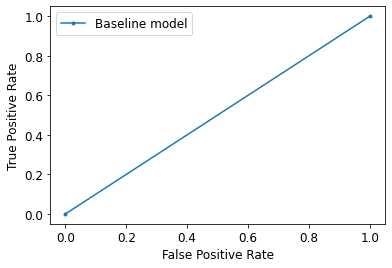

In [28]:
lr_auc = roc_auc_score(y_true, y_pred)
print('ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Baseline model')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [ ]:
pr_auc = average_precision_score(y_true, y_pred)
print("PR AUC:", specificity)